In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.optim as optim
import numpy as np
from tqdm import tqdm

from uitilities import *


In [3]:
train_file_path = "hull-tactical-market-prediction/train.csv"
test_file_path = "hull-tactical-market-prediction/test.csv"
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (8990, 98)


## Preprocess

In [4]:
importance_results = ['V13', 'V7', 'E19', 'P5', 'S5', 'M17', 'S2', 'V9', 'E11', 'S8', 'M4',
       'E12', 'I2', 'P8', 'E18', 'M18', 'V10', 'E6', 'I9', 'E9', 'E16', 'P10',
       'I5', 'M1', 'M12', 'E17', 'M8', 'E15', 'M10', 'V6', 'V1', 'P7', 'P12',
       'M5', 'M2', 'P11', 'I4', 'I3', 'E8', 'S7', 'M3', 'S9', 'V5', 'M11',
       'M7', 'E1', 'E2', 'E20', 'D1', 'D2', 'V12', 'E3', 'S12', 'D8', 'D4',
       'M14', 'S6', 'S3', 'P2', 'E7', 'E10', 'V8', 'D6', 'E5', 'P6', 'I7',
       'D5', 'S10', 'S1', 'D7', 'V11', 'P3', 'M13', 'P4', 'E13', 'I1', 'P9',
       'S4', 'M6', 'M16', 'M9', 'I8', 'D3', 'E4', 'I6', 'E14', 'M15', 'P13',
       'V4', 'S11', 'P1', 'V2', 'V3', 'D9']
print(importance_results[-10:])
print(len(importance_results))

['I6', 'E14', 'M15', 'P13', 'V4', 'S11', 'P1', 'V2', 'V3', 'D9']
94


In [5]:
def create_allocation_target(returns, method='sigmoid', scaling=100):
    """
    Maps excess returns to an allocation between 0.0 and 2.0.
    
    Parameters:
    - returns: Series or array of adjusted_returns
    - scaling: Controls steepness. Higher = more aggressive leverage on small returns.
    """
    if method == 'sigmoid':
        # Maps 0 return -> 1.0 allocation (neutral)
        # Maps +inf return -> 2.0 allocation
        # Maps -inf return -> 0.0 allocation
        return 2.0 / (1.0 + np.exp(-scaling * returns))
    
    elif method == 'linear':
        # Simple linear scaling centered at 1.0
        # You may need to tune 'scaling' (alpha) based on return volatility
        return np.clip(1.0 + scaling * returns, 0.0, 2.0)
        
    elif method == 'binary':
        # Hard 0 or 2 mapping
        return np.where(returns > 0, 2.0, 0.0)

In [6]:
def create_training_target_allocation(
    forward_returns_series: pd.Series, 
    span_N: int = 60, 
    sensitivity_k: float = 1.0
) -> np.ndarray:
    """
    Generates the 'Ground Truth' Allocation for TRAINING.
    
    Formula: 
       Target = tanh( Future_Return / Current_Volatility * k )
       Then mapped to [0, 2]
    """
    
    # 1. Calculate Volatility (Risk) using PAST data only
    # We use .shift(1) because at time t, we don't know the forward return of t.
    # We only know the returns up to t.
    past_returns = forward_returns_series.shift(1).fillna(0)
    
    # Calculate realized variance (Vol^2)
    # EWM is standard for 'Current Risk Regime'
    ewma_vol = past_returns.ewm(span=span_N, min_periods=span_N//2).std()
    
    # Fill initial NaNs with global std to prevent division by zero
    ewma_vol = ewma_vol.fillna(ewma_vol.mean())
    
    # Clip volatility to avoid exploding signals on 0-vol days
    ewma_vol = ewma_vol.clip(lower=1e-6)
    
    # 2. Normalize the FUTURE Return by the PAST Volatility
    # This creates a "Realized Sharpe" for the next day
    normalized_signal = forward_returns_series / ewma_vol
    
    # 3. Apply the tanh squeeze (The 'Policy' part)
    # Result is between -1 and 1
    allocation_signal = np.tanh(normalized_signal * sensitivity_k)
    
    # 4. Map to Hull Tactical Constraints [0, 2]
    # Logic: 
    #   If signal > 0: Go Long (Scale up to 2.0)
    #   If signal <= 0: Go Cash (0.0) -> No Shorting allowed in this specific mapping
    
    # Note: If you want to allow "Shorting" logic to map to 0 (Cash), use max(0, ...)
    final_allocation = np.maximum(0.0, allocation_signal) * 2.0
    
    return final_allocation

In [7]:
TARGET = "target_allocation"
FEATURES_TO_DROP = ["market_forward_excess_returns"]
FEATURES = [col for col in train_df.columns if col not in [TARGET] + FEATURES_TO_DROP]


print("Preparing features (X)...")
X = train_df[FEATURES].copy()
X['forward_returns_lag'] = X['forward_returns'].shift(1)
X['risk_free_rate_lag'] = X['risk_free_rate'].shift(1)
X.drop('forward_returns', axis = 1, inplace = True)
X.drop('risk_free_rate', axis =1, inplace = True)

print("Preparing target (y) for model training...")
# create target allocation
train_df['adjusted_return'] = train_df['forward_returns'] - train_df['risk_free_rate']
train_df['target_allocation'] = create_allocation_target(train_df['adjusted_return'], method='sigmoid', scaling=100) 
#train_df['target_allocation'] = create_training_target_allocation(train_df['forward_returns'], span_N=60, sensitivity_k=1.0)
y = train_df[TARGET].copy()


#———————————————————————————————————————————————————————————————————————————————————————

N_TEST_ROWS = 180
print(f"Splitting data into train/test with N_TEST_ROWS={N_TEST_ROWS}")

X_test = X.iloc[-N_TEST_ROWS:]
y_test = y.iloc[-N_TEST_ROWS:]  
X_train = X.iloc[:-N_TEST_ROWS]
y_train = y.iloc[:-N_TEST_ROWS]
X = X_train
y = y_train

# --- 5. 打印和验证 ---
print("--- For Model Training ---")
print("X_train shape: {}".format(X_train.shape))
print("y_train (target_allocation) shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test (target_allocation) shape: {}".format(y_test.shape))

print("\n--- NA Counts (in Train set) ---")
print(f"X_train NAs: {X_train.isna().any().sum()}")
print(f"y_train NAs: {y_train.isna().any().sum()}")

print(y[:10])

Preparing features (X)...
Preparing target (y) for model training...
Splitting data into train/test with N_TEST_ROWS=180
--- For Model Training ---
X_train shape: (8810, 97)
y_train (target_allocation) shape: (8810,)
X_test shape: (180, 97)
y_test (target_allocation) shape: (180,)

--- NA Counts (in Train set) ---
X_train NAs: 87
y_train NAs: 0
0    0.864736
1    0.586461
2    0.540811
3    1.214763
4    0.463485
5    0.674800
6    1.165786
7    0.153612
8    0.586793
9    1.499221
Name: target_allocation, dtype: float64


In [8]:
def create_drop_features(df: pd.DataFrame, log = True) -> pd.DataFrame:
    # """Create features based on domain knowledge and drop unnecessary columns.
    #global log
    
    I_cols = ['M4_roll_mean_5', 'M4', 'V13', 'M4_lag_1', 'S12', 'forward_returns_lag_roll_mean_5', 'S5_lag_1', 
    'S5_roll_mean_20', 'forward_returns_lag', 'I2', 'S2', 'P7', 'P5', 'M17', 'S2_lag_1',  'M2', 'S5', 
    'V7', 'S5_roll_mean_60', 'S2_roll_std_60', 'M17_lag_1', 'V12', 'M17_lag_5', 'M11', 'forward_returns_lag_lag_1', 
    'M8', 'M17_lag_20', 'S2_roll_mean_5', 'S2_roll_mean_20', 'E19_roll_std_5', 'E11', 'P10', 'V8', 'forward_returns_lag_roll_mean_60', 
    'M17_roll_mean_20', 'M12', 'E11_roll_std_20', 'E11_lag_20', 'S5_roll_mean_5',"feat_I2_poshinge_x_M17low"]
    
    MP_cols = ["feat_M4_minus_P7", "feat_M17_minus_P5"]
    SV_cols = []
    
    df_out = df.copy()
    
    TOP_FEATURES= ['forward_returns_lag', 'M4','M17','S5','S2','E19','E11']
    SEP_cols = ['date_id', 'forward_returns', 'risk_free_rate']
    LAG_PERIODS = [1, 5, 20]
    ROLLING_WINDOWS = [5, 20, 60]
    COLS_TO_DROP =  ['date_id', 'risk_free_rate_lag']
    features_dict = {}
    '''
    # Create lag and rolling statistics features
    for col in TOP_FEATURES:
        if col in df_out.columns:
            for lag in LAG_PERIODS:
                features_dict[f'{col}_lag_{lag}'] = df_out[col].shift(lag)
            for window in ROLLING_WINDOWS:
                features_dict[f'{col}_roll_mean_{window}'] = df_out[col].rolling(window=window, min_periods=1).mean()
                features_dict[f'{col}_roll_std_{window}'] = df_out[col].rolling(window=window, min_periods=1).std()
                
    df_out = pd.concat([df_out, pd.DataFrame(features_dict)], axis=1)
    epsilon = 1e-6 # 防止除以零
    '''
    '''
    if 'I2' in df_out.columns and 'M17' in df_out.columns:
        m17_thr = df_out["M17"].median()  # tune if you prefer a fixed value
        df_out["feat_I2_poshinge_x_M17low"] = np.maximum(df_out["I2"], 0.0) * (df_out["M17"] < m17_thr).astype(float)

    df_out["feat_S12_minu_V7"] = df_out['S12']  - df_out['V7'] 
    df_out["feat_M4_minus_P7"] = df_out["M4"] - df_out["P7"]
    df_out["feat_M17_minus_P5"] = df_out["M17"] - df_out["P5"]
    if 'M4' in df_out.columns and 'E19' in df_out.columns:
        df_out['feat_M4_x_E19'] = df_out['M4'] * df_out['E19']

    if 'P7' in df_out.columns and 'V7' in df_out.columns:
        df_out['feat_P7_x_V7'] = df_out['P7'] * df_out['V7']

    if 'S5' in df_out.columns and 'E11' in df_out.columns:
        df_out['feat_S5_x_E11'] = df_out['S5'] * df_out['E11']
        
    if 'feat_M4_minus_P7' in df_out.columns and 'E19' in df_out.columns:
        df_out['feat_M4_P7_x_E19'] = df_out['feat_M4_minus_P7'] * df_out['E19']
    '''
    
    df_out.drop(columns = [col for col in COLS_TO_DROP if col in df_out.columns], inplace = True)
    
    COLS_TO_KEEP = set(I_cols + MP_cols + SV_cols + importance_results[:30])
    df_out = df_out[[col for col in COLS_TO_KEEP if col in df_out.columns]]
    df_out.fillna(0, inplace=True)
    if (log):
        print(f"Feature X: {df_out.columns.tolist()}")
        print(f"Feature Creator Output Shape: {df_out.shape}")
        log = False
    return df_out

In [9]:
# test create_drop_features
#X_train = create_drop_features(X_train)
#X_test = create_drop_features(X_test)

#print("Full train dataset shape is {}".format(train_df.shape))

In [10]:
# --------- 2. Temporal window creator (Updated) ---------
def create_windows(X_df, y_series, returns_series, window):
    X = X_df.values
    y = y_series.values
    r = returns_series.values # Raw returns for Sharpe calc

    N = len(X)
    
    X_out = []
    y_out = []
    r_out = []

    for t in range(window, N):
        X_out.append(X[t-window:t].T)  # (F, W) transposed to match CNN input (Batch, Channels, length)
        y_out.append(y[t])             # Target allocation
        r_out.append(r[t])             # Raw return for this day

    X_out = np.stack(X_out)
    y_out = np.array(y_out)
    r_out = np.array(r_out)
    return X_out, y_out, r_out

# --------- 3. PyTorch Dataset (Updated) ---------
class TemporalDataset(Dataset):
    def __init__(self, X, y, returns):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.returns = torch.tensor(returns, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Returns: Inputs, Target Allocation, Raw Return
        return self.X[idx], self.y[idx], self.returns[idx]

In [11]:
# test create_windows
#X_temp = create_drop_features(X_train)
#X_windows, y_windows = create_windows(X_temp, y_train, window=10)

## CNN

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import weight_norm  # <--- Essential for TCN stability

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation, kernel_size=3, dropout=0.2):
        super().__init__()
        
        # Calculate padding to ensure output length == input length after slicing
        padding = (kernel_size - 1) * dilation 

        # BLOCK 1: Weight Norm + Conv + Chomp + ReLU + Dropout
        self.conv1 = weight_norm(nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=padding, dilation=dilation
        ))
        self.chomp1 = padding  # Store how much to slice off
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # BLOCK 2: Same structure
        self.conv2 = weight_norm(nn.Conv1d(
            out_channels, out_channels, kernel_size,
            padding=padding, dilation=dilation
        ))
        self.chomp2 = padding
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # RESIDUAL CONNECTION: Downsample if dimensions don't match
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu_final = nn.ReLU()

    def forward(self, x):
        # Path A: The Transformation
        out = self.conv1(x)
        out = out[:, :, :-self.chomp1] # Causal Slicing (Remove Future)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = out[:, :, :-self.chomp2] # Causal Slicing
        out = self.relu2(out)
        out = self.dropout2(out)

        # Path B: The Residual
        res = x if self.downsample is None else self.downsample(x)
        
        # Merge
        return self.relu_final(out + res)

class MarketTCN(nn.Module):
    def __init__(self, num_features, hidden=128, levels=4, kernel_size=3, dropout=0.2):
        super().__init__()
        
        layers = []
        in_channels = num_features
        
        for i in range(levels):
            dilation = 2 ** i
            layers.append(
                TemporalBlock(in_channels, hidden, dilation, kernel_size, dropout)
            )
            in_channels = hidden # Next layer input is this layer's output

        self.network = nn.Sequential(*layers)
        
        # FIX: Input dim is just 'hidden', not 'hidden * window'
        self.head = nn.Linear(hidden, 1) 
        
    def forward(self, x):
        # x shape: (Batch, Features, Window)
        
        # Pass through TCN blocks
        y = self.network(x) # Output: (Batch, Hidden, Window)
        
        # FIX: Take only the LAST time step (contains aggregated history)
        # We don't care about the prediction for t-10, only for t (today)
        last_step = y[:, :, -1] 
        
        # Projection to scalar
        logits = self.head(last_step)
        
        # FIX: Sigmoid map to [0, 2]
        return torch.sigmoid(logits) * 2.0

In [13]:
# test network
model = MarketTCN(num_features=37)
print(model)

MarketTCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): ParametrizedConv1d(
        37, 128, kernel_size=(3,), stride=(1,), padding=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): ParametrizedConv1d(
        128, 128, kernel_size=(3,), stride=(1,), padding=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (downsample): Conv1d(37, 128, kernel_size=(1,), stride=(1,))
      (relu_final): ReLU()
    )
    (1): TemporalBlock(
      (conv1): ParametrizedConv1d(
        128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
      

### test model

In [14]:
def ad_sharpe_ratio_scorer(y_pred, y):
    
    y_pred = y_pred.astype(float)
    y_true = y.astype(float)
    
    # 3. 计算策略的每日收益
    # 策略逻辑：预测为正时买入，预测为负时不操作
    positions = np.where(y_pred > 0, y_pred, 0)
    #positions = np.clip(positions, 0, 2)
    strategy_returns = positions * y_true
        
    # 4. 计算夏普比率
    mean_return = np.mean(strategy_returns)
    std_return = np.std(strategy_returns)
    
    # 增加一个小的 epsilon 以避免除以零
    epsilon = 1e-8
    sharpe_ratio = mean_return / (std_return + epsilon)
    
    # 5. 返回夏普比率。scikit-learn 会尝试最大化这个值。
    return sharpe_ratio

In [15]:
def train_hull_model_with_early_stopping(model, train_loader, val_loader, epochs=50, patience=5, device='cuda'):
    """
    Training loop with Early Stopping based on Validation Sharpe Ratio.
    """
    model = model.to(device)
    
    # Robust Loss Function
    criterion = nn.SmoothL1Loss()
    
    # Optimizer & Scheduler
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=0.005, 
        steps_per_epoch=len(train_loader), 
        epochs=epochs
    )
    
    # --- Early Stopping Variables ---
    best_sharpe = -np.inf
    patience_counter = 0  # Tracks how many epochs without improvement
    best_model_path = 'best_hull_model.pth'
    
    history = {'train_loss': [], 'val_loss': [], 'val_sharpe': []}

    print(f"Starting training on {device} with Patience={patience}...")
    
    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()
        train_loss_sum = 0
        
        for batch_X, batch_y, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            preds = model(batch_X).view(-1)
            loss = criterion(preds, batch_y)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            train_loss_sum += loss.item()

        # --- VALIDATION PHASE ---
        model.eval()
        val_loss_sum = 0
        all_preds = []
        all_raw_returns = []
        
        with torch.no_grad():
            for batch_X, batch_y_target, batch_raw_returns in val_loader:
                batch_X, batch_y_target = batch_X.to(device), batch_y_target.to(device)
                
                preds = model(batch_X).view(-1)
                loss = criterion(preds, batch_y_target)
                val_loss_sum += loss.item()
                
                # Store for Sharpe Calc
                all_preds.extend(preds.cpu().numpy())
                all_raw_returns.extend(batch_raw_returns.numpy())

        # --- METRICS & EARLY STOPPING ---
        avg_train_loss = train_loss_sum / len(train_loader)
        avg_val_loss = val_loss_sum / len(val_loader)
        
        # Calculate Sharpe
        strategy_returns = np.array(all_preds) * np.array(all_raw_returns)
        std_dev = np.std(strategy_returns)
        sharpe = (np.mean(strategy_returns) / (std_dev + 1e-8)) * np.sqrt(252)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_sharpe'].append(sharpe)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Val Sharpe={sharpe:.4f}")

        # Check for Improvement
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            patience_counter = 0  # Reset counter
            torch.save(model.state_dict(), best_model_path)
            print(f"  --> New Best Model Saved! (Sharpe: {best_sharpe:.4f})")
        else:
            patience_counter += 1
            print(f"  --> No improvement. Patience: {patience_counter}/{patience}")
            
            # Stop if patience runs out
            if patience_counter >= patience:
                print(f"\n[Early Stopping] Triggered at Epoch {epoch+1}. Best Sharpe: {best_sharpe:.4f}")
                break
    
    # Load the best weights before returning
    model.load_state_dict(torch.load(best_model_path))
    return history

In [16]:
# Prepare DataLoaders

# ----- Hyperparameters -----
WINDOW = 32
BATCH = 32
LR = 1e-3
EPOCHS = 20

from sklearn.preprocessing import StandardScaler

# ----- Rebuild X_train/X_test -----
X_train_f = create_drop_features(X_train)
X_test_f = create_drop_features(X_test)

# detrend data
cnn_feature_categories = categorize_features(X_train_f)
X_train_f = detrend_and_standardize(X_train_f, cnn_feature_categories)
X_test_f = detrend_and_standardize(X_test_f, cnn_feature_categories)

# --- NEW: Feature Scaling ---
scaler = StandardScaler()
# Fit on TRAIN only to avoid leakage
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_f), columns=X_train_f.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_f), columns=X_test_f.columns)

# Get the raw returns corresponding to these sets
# Note: We need to align them because create_drop_features might not change row count, 
# but we need to be sure we are passing the correct series.
# Assuming X_train/y_train indices are aligned with the original df:
train_returns = train_df.loc[X_train.index, 'adjusted_return'] # Or 'forward_returns'
test_returns = train_df.loc[X_test.index, 'adjusted_return']

# Create window tensors with the 3rd argument
Xw_train, yw_train, rw_train = create_windows(X_train_scaled, y_train, train_returns, WINDOW)
Xw_test, yw_test, rw_test = create_windows(X_test_scaled, y_test, test_returns, WINDOW)

train_ds = TemporalDataset(Xw_train, yw_train, rw_train)
test_ds  = TemporalDataset(Xw_test, yw_test, rw_test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

num_features = Xw_train.shape[1]
print(f"Number of features: {num_features}")


Feature X: ['E15', 'S5', 'E17', 'I5', 'S12', 'M4', 'V8', 'V13', 'E11', 'M1', 'V12', 'V9', 'E19', 'V7', 'M12', 'M10', 'S2', 'E9', 'M11', 'M18', 'S8', 'M2', 'E12', 'V6', 'I9', 'I2', 'M8', 'E16', 'P5', 'P7', 'M17', 'P10', 'forward_returns_lag', 'E6', 'P8', 'E18', 'V10']
Feature Creator Output Shape: (8810, 37)
Feature X: ['E15', 'S5', 'E17', 'I5', 'S12', 'M4', 'V8', 'V13', 'E11', 'M1', 'V12', 'V9', 'E19', 'V7', 'M12', 'M10', 'S2', 'E9', 'M11', 'M18', 'S8', 'M2', 'E12', 'V6', 'I9', 'I2', 'M8', 'E16', 'P5', 'P7', 'M17', 'P10', 'forward_returns_lag', 'E6', 'P8', 'E18', 'V10']
Feature Creator Output Shape: (180, 37)

🏷️ FEATURE CATEGORIZATION
📊 Market_Dynamics: 9 features
📊 Macro_Economic: 9 features
📊 Interest_Rate: 3 features
📊 Price_Valuation: 4 features
📊 Volatility: 7 features
📊 Sentiment: 4 features
📊 Momentum: 0 features
📊 Dummy_Binary: 0 features
📊 Special: 0 features

📈 Total categorized features: 36
📈 Total columns in dataset: 37
Number of features: 37


In [17]:
#model = MarketTCN(num_features=num_features)
#print(model)
#trained_model = train_hull_model(model, train_loader, test_loader, epochs=EPOCHS, device='cuda')

# Step-Forward Validation for TCN Model

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Step-forward validation parameters
n_samples = len(X)
initial_train_size = int(n_samples * 0.2)  # Start with 20% for initial training
test_size = int(n_samples * 0.1)  # 10% for each test window

# Storage for results
tcn_sharpe_scores = []
tcn_r2_scores = []
tcn_hit_rates = []
all_test_indices = []
all_y_true = []
all_tcn_preds = []

# Helper function to calculate Sharpe ratio
def calculate_sharpe_ratio(predictions, true_returns):
    """Calculate annualized Sharpe ratio from predictions and true returns."""
    strategy_returns = predictions * true_returns
    if len(strategy_returns) == 0 or strategy_returns.std() == 0:
        return 0.0
    sharpe = strategy_returns.mean() / strategy_returns.std()
    return sharpe * np.sqrt(252)  # Annualize

# Step-forward validation loop
train_start_index = 0
train_end_index = initial_train_size
test_end_index = train_end_index + test_size

print(f"Starting step-forward validation...")
print(f"Initial training size: {initial_train_size} samples")
print(f"Test window size: {test_size} samples")
print(f"Total samples: {n_samples}\n")

fold_num = 0
while test_end_index <= n_samples:
    fold_num += 1
    print(f"\n{'='*60}")
    print(f"Fold {fold_num}: Train [{train_start_index}:{train_end_index}] | Test [{train_end_index}:{test_end_index}]")
    print(f"{'='*60}")
    
    # Split data for this fold
    X_fold_train = X.iloc[train_start_index:train_end_index]
    y_fold_train = y.iloc[train_start_index:train_end_index]
    r_fold_train = train_df['adjusted_return'].iloc[train_start_index:train_end_index]
    
    # --- FIX START: Test Split with Buffer ---
    # We need strictly 'test_size' PREDICTIONS, so we need 'test_size + WINDOW' INPUTS
    buffer_start = train_end_index - WINDOW
    
    X_fold_test = X.iloc[buffer_start:test_end_index]
    y_fold_test = y.iloc[buffer_start:test_end_index]
    r_fold_test = train_df['adjusted_return'].iloc[buffer_start:test_end_index]
    # --- FIX END ---
    
    # Apply feature engineering
    X_fold_train_f = create_drop_features(X_fold_train, log=False)
    X_fold_test_f = create_drop_features(X_fold_test, log=False)
    
    # Standardize features
    fold_scaler = StandardScaler()
    X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train_f)
    X_fold_test_scaled = fold_scaler.transform(X_fold_test_f)
    
    # Convert back to DataFrames
    X_fold_train_scaled = pd.DataFrame(X_fold_train_scaled, columns=X_fold_train_f.columns, index=X_fold_train_f.index)
    X_fold_test_scaled = pd.DataFrame(X_fold_test_scaled, columns=X_fold_test_f.columns, index=X_fold_test_f.index)
    
    # Create temporal windows
    Xw_fold_train, yw_fold_train, rw_fold_train = create_windows(
        X_fold_train_scaled, y_fold_train, r_fold_train, WINDOW
    )
    Xw_fold_test, yw_fold_test, rw_fold_test = create_windows(
        X_fold_test_scaled, y_fold_test, r_fold_test, WINDOW
    )
    
    print(f"Training samples after windowing: {len(Xw_fold_train)}")
    print(f"Test samples after windowing: {len(Xw_fold_test)}")
    
    # Create datasets and loaders
    fold_train_ds = TemporalDataset(Xw_fold_train, yw_fold_train, rw_fold_train)
    fold_test_ds = TemporalDataset(Xw_fold_test, yw_fold_test, rw_fold_test)
    
    fold_train_loader = DataLoader(fold_train_ds, batch_size=BATCH, shuffle=True)
    fold_test_loader = DataLoader(fold_test_ds, batch_size=BATCH, shuffle=False)
    
    # Initialize fresh model for this fold
    fold_model = MarketTCN(
        num_features=X_fold_train_scaled.shape[1],
        levels=4,   
        hidden=64,
        kernel_size=3
    ).to('cuda')
    
    # Train model on this fold
    print(f"\nTraining TCN model for fold {fold_num}...")
    fold_trained = train_hull_model_with_early_stopping(
        model=fold_model,
        train_loader=fold_train_loader,
        val_loader=fold_test_loader,
        epochs=EPOCHS,
        device='cuda'
    )
    
    # Make predictions on test set
    fold_model.eval()
    fold_preds = []
    fold_true = []
    fold_returns = []
    
    with torch.no_grad():
        for X_batch, y_batch, r_batch in fold_test_loader:
            X_batch = X_batch.to('cuda')
            outputs = fold_model(X_batch)
            fold_preds.extend(outputs.cpu().numpy())
            fold_true.extend(y_batch.numpy())
            fold_returns.extend(r_batch.numpy())
    
    fold_preds = np.array(fold_preds).flatten()
    fold_true = np.array(fold_true)
    fold_returns = np.array(fold_returns)
    
    # Calculate metrics for this fold
    # Pass allocations directly - the scorer handles position sizing
    fold_sharpe = ad_sharpe_ratio_scorer(fold_preds, fold_returns)
    fold_r2 = r2_score(fold_true, fold_preds)
    
    # calculate hitrate
    # 1. Shift allocation to center around 0
    # Range becomes [-1.0, +1.0]
    # Positive = "I expect market to go UP"
    # Negative = "I expect market to go DOWN (or be risky)"
    active_decision = fold_preds - 1.0
    # 2. Calculate Hit Rate
    # We match the SIGN of the decision with the SIGN of the market return
    hits = np.sign(active_decision) == np.sign(fold_returns)
    # 3. Final Metric
    fold_hit_rate = np.mean(hits)
    
    # Store results
    tcn_sharpe_scores.append(fold_sharpe)
    tcn_r2_scores.append(fold_r2)
    tcn_hit_rates.append(fold_hit_rate)
    all_test_indices.append(y_fold_test.index[WINDOW:])  # Account for windowing
    all_y_true.append(fold_true)
    all_tcn_preds.append(fold_preds)
    
    print(f"\nFold {fold_num} Results:")
    print(f"  Sharpe Ratio: {fold_sharpe:.4f}")
    print(f"  R² Score: {fold_r2:.4f}")
    print(f"  Hit Rate: {fold_hit_rate:.4f}")
    
    # Move to next fold
    train_start_index += test_size
    train_end_index += test_size
    test_end_index += test_size

# Print overall summary
print(f"\n{'='*60}")
print("STEP-FORWARD VALIDATION SUMMARY")
print(f"{'='*60}")
print(f"\nTCN Model Performance Across {fold_num} Folds:")
print(f"  Sharpe Ratios: {[f'{s:.4f}' for s in tcn_sharpe_scores]}")
print(f"  Mean Sharpe Ratio: {np.mean(tcn_sharpe_scores):.4f} ± {np.std(tcn_sharpe_scores):.4f}")
print(f"\n  R² Scores: {[f'{s:.4f}' for s in tcn_r2_scores]}")
print(f"  Mean R² Score: {np.mean(tcn_r2_scores):.4f} ± {np.std(tcn_r2_scores):.4f}")
print(f"\n  Hit Rates: {[f'{s:.4f}' for s in tcn_hit_rates]}")
print(f"  Mean Hit Rate: {np.mean(tcn_hit_rates):.4f} ± {np.std(tcn_hit_rates):.4f}")
print(f"{'='*60}\n")

Starting step-forward validation...
Initial training size: 1762 samples
Test window size: 881 samples
Total samples: 8810


Fold 1: Train [0:1762] | Test [1762:2643]
Training samples after windowing: 1730
Test samples after windowing: 881

Training TCN model for fold 1...
Starting training on cuda with Patience=5...


Epoch 1: Train Loss=0.0536 | Val Loss=0.5638 | Val Sharpe=0.7164
  --> New Best Model Saved! (Sharpe: 0.7164)


Epoch 2: Train Loss=0.0509 | Val Loss=0.5609 | Val Sharpe=0.7360
  --> New Best Model Saved! (Sharpe: 0.7360)


Epoch 3: Train Loss=0.0496 | Val Loss=0.5577 | Val Sharpe=0.7124
  --> No improvement. Patience: 1/5


Epoch 4: Train Loss=0.0494 | Val Loss=0.5613 | Val Sharpe=0.6908
  --> No improvement. Patience: 2/5


Epoch 5: Train Loss=0.0511 | Val Loss=0.5489 | Val Sharpe=0.7175
  --> No improvement. Patience: 3/5


Epoch 6: Train Loss=0.0501 | Val Loss=0.5099 | Val Sharpe=0.7993
  --> New Best Model Saved! (Sharpe: 0.7993)


Epoch 7: Train Loss=0.0504 | Val Loss=0.2628 | Val Sharpe=1.0297
  --> New Best Model Saved! (Sharpe: 1.0297)


Epoch 8: Train Loss=0.0503 | Val Loss=0.1548 | Val Sharpe=0.8708
  --> No improvement. Patience: 1/5


Epoch 9: Train Loss=0.0477 | Val Loss=0.5093 | Val Sharpe=0.8864
  --> No improvement. Patience: 2/5


Epoch 10: Train Loss=0.0476 | Val Loss=0.2940 | Val Sharpe=0.8280
  --> No improvement. Patience: 3/5


Epoch 11: Train Loss=0.0487 | Val Loss=0.5261 | Val Sharpe=0.7718
  --> No improvement. Patience: 4/5


Epoch 12: Train Loss=0.0458 | Val Loss=0.1418 | Val Sharpe=1.0462
  --> New Best Model Saved! (Sharpe: 1.0462)


Epoch 13: Train Loss=0.0443 | Val Loss=0.3273 | Val Sharpe=0.8945
  --> No improvement. Patience: 1/5


Epoch 14: Train Loss=0.0426 | Val Loss=0.4994 | Val Sharpe=0.9475
  --> No improvement. Patience: 2/5


Epoch 15: Train Loss=0.0419 | Val Loss=0.4796 | Val Sharpe=0.9283
  --> No improvement. Patience: 3/5


Epoch 16: Train Loss=0.0412 | Val Loss=0.1643 | Val Sharpe=0.9071
  --> No improvement. Patience: 4/5


Epoch 17: Train Loss=0.0392 | Val Loss=0.4261 | Val Sharpe=0.9291
  --> No improvement. Patience: 5/5

[Early Stopping] Triggered at Epoch 17. Best Sharpe: 1.0462

Fold 1 Results:
  Sharpe Ratio: 0.0659
  R² Score: -0.2783
  Hit Rate: 0.5176

Fold 2: Train [881:2643] | Test [2643:3524]
Training samples after windowing: 1730
Test samples after windowing: 881

Training TCN model for fold 2...
Starting training on cuda with Patience=5...


Epoch 1: Train Loss=0.0823 | Val Loss=0.1292 | Val Sharpe=-0.3892
  --> New Best Model Saved! (Sharpe: -0.3892)


Epoch 2: Train Loss=0.0776 | Val Loss=0.1240 | Val Sharpe=-0.3470
  --> New Best Model Saved! (Sharpe: -0.3470)


Epoch 3: Train Loss=0.0774 | Val Loss=0.1260 | Val Sharpe=-0.3872
  --> No improvement. Patience: 1/5


Epoch 4: Train Loss=0.0767 | Val Loss=0.1290 | Val Sharpe=-0.4037
  --> No improvement. Patience: 2/5


Epoch 5: Train Loss=0.0772 | Val Loss=0.1239 | Val Sharpe=-0.3757
  --> No improvement. Patience: 3/5


Epoch 6: Train Loss=0.0766 | Val Loss=0.1211 | Val Sharpe=-0.3396
  --> New Best Model Saved! (Sharpe: -0.3396)


Epoch 7: Train Loss=0.0737 | Val Loss=0.1213 | Val Sharpe=-0.3019
  --> New Best Model Saved! (Sharpe: -0.3019)


Epoch 8: Train Loss=0.0717 | Val Loss=0.1304 | Val Sharpe=-0.3224
  --> No improvement. Patience: 1/5


Epoch 9: Train Loss=0.0722 | Val Loss=0.1277 | Val Sharpe=-0.3185
  --> No improvement. Patience: 2/5


Epoch 10: Train Loss=0.0711 | Val Loss=0.1236 | Val Sharpe=-0.2845
  --> New Best Model Saved! (Sharpe: -0.2845)


Epoch 11: Train Loss=0.0672 | Val Loss=0.1230 | Val Sharpe=-0.2212
  --> New Best Model Saved! (Sharpe: -0.2212)


Epoch 12: Train Loss=0.0640 | Val Loss=0.1277 | Val Sharpe=-0.1967
  --> New Best Model Saved! (Sharpe: -0.1967)


Epoch 13: Train Loss=0.0629 | Val Loss=0.1355 | Val Sharpe=-0.2752
  --> No improvement. Patience: 1/5


Epoch 14: Train Loss=0.0624 | Val Loss=0.1289 | Val Sharpe=-0.2206
  --> No improvement. Patience: 2/5


Epoch 15: Train Loss=0.0560 | Val Loss=0.1399 | Val Sharpe=-0.2706
  --> No improvement. Patience: 3/5


Epoch 16: Train Loss=0.0538 | Val Loss=0.1319 | Val Sharpe=-0.2150
  --> No improvement. Patience: 4/5


Epoch 17: Train Loss=0.0477 | Val Loss=0.1366 | Val Sharpe=-0.2385
  --> No improvement. Patience: 5/5

[Early Stopping] Triggered at Epoch 17. Best Sharpe: -0.1967

Fold 2 Results:
  Sharpe Ratio: -0.0124
  R² Score: -0.0549
  Hit Rate: 0.5153

Fold 3: Train [1762:3524] | Test [3524:4405]
Training samples after windowing: 1730
Test samples after windowing: 881

Training TCN model for fold 3...
Starting training on cuda with Patience=5...


Epoch 1: Train Loss=0.1224 | Val Loss=0.0555 | Val Sharpe=0.7171
  --> New Best Model Saved! (Sharpe: 0.7171)


Epoch 2: Train Loss=0.1176 | Val Loss=0.0565 | Val Sharpe=0.7407
  --> New Best Model Saved! (Sharpe: 0.7407)


Epoch 3: Train Loss=0.1184 | Val Loss=0.1042 | Val Sharpe=0.8128
  --> New Best Model Saved! (Sharpe: 0.8128)


Epoch 4: Train Loss=0.1174 | Val Loss=0.0551 | Val Sharpe=0.8250
  --> New Best Model Saved! (Sharpe: 0.8250)


Epoch 5: Train Loss=0.1158 | Val Loss=0.0480 | Val Sharpe=0.7992
  --> No improvement. Patience: 1/5


Epoch 6: Train Loss=0.1156 | Val Loss=0.0533 | Val Sharpe=0.8211
  --> No improvement. Patience: 2/5


Epoch 7: Train Loss=0.1143 | Val Loss=0.0696 | Val Sharpe=0.8546
  --> New Best Model Saved! (Sharpe: 0.8546)


Epoch 8: Train Loss=0.1151 | Val Loss=0.0663 | Val Sharpe=0.8827
  --> New Best Model Saved! (Sharpe: 0.8827)


Epoch 9: Train Loss=0.1116 | Val Loss=0.0509 | Val Sharpe=0.7861
  --> No improvement. Patience: 1/5


Epoch 10: Train Loss=0.1097 | Val Loss=0.1287 | Val Sharpe=0.8424
  --> No improvement. Patience: 2/5


Epoch 11: Train Loss=0.1050 | Val Loss=0.0658 | Val Sharpe=0.8267
  --> No improvement. Patience: 3/5


Epoch 12: Train Loss=0.1000 | Val Loss=0.0701 | Val Sharpe=0.8037
  --> No improvement. Patience: 4/5


Epoch 13: Train Loss=0.1002 | Val Loss=0.0697 | Val Sharpe=0.7767
  --> No improvement. Patience: 5/5

[Early Stopping] Triggered at Epoch 13. Best Sharpe: 0.8827

Fold 3 Results:
  Sharpe Ratio: 0.0556
  R² Score: -0.4658
  Hit Rate: 0.5585

Fold 4: Train [2643:4405] | Test [4405:5286]
Training samples after windowing: 1730
Test samples after windowing: 881

Training TCN model for fold 4...
Starting training on cuda with Patience=5...


Epoch 1: Train Loss=0.0897 | Val Loss=0.2877 | Val Sharpe=0.1158
  --> New Best Model Saved! (Sharpe: 0.1158)


Epoch 2: Train Loss=0.0821 | Val Loss=0.2538 | Val Sharpe=0.1159
  --> New Best Model Saved! (Sharpe: 0.1159)


Epoch 3: Train Loss=0.0862 | Val Loss=0.1506 | Val Sharpe=0.0673
  --> No improvement. Patience: 1/5


Epoch 4: Train Loss=0.0828 | Val Loss=0.2494 | Val Sharpe=0.1145
  --> No improvement. Patience: 2/5


Epoch 5: Train Loss=0.0815 | Val Loss=0.2311 | Val Sharpe=0.1261
  --> New Best Model Saved! (Sharpe: 0.1261)


Epoch 6: Train Loss=0.0807 | Val Loss=0.1467 | Val Sharpe=0.0465
  --> No improvement. Patience: 1/5


Epoch 7: Train Loss=0.0830 | Val Loss=0.2003 | Val Sharpe=0.0829
  --> No improvement. Patience: 2/5


Epoch 8: Train Loss=0.0837 | Val Loss=0.2647 | Val Sharpe=0.1091
  --> No improvement. Patience: 3/5


Epoch 9: Train Loss=0.0834 | Val Loss=0.1775 | Val Sharpe=-0.0552
  --> No improvement. Patience: 4/5


Epoch 10: Train Loss=0.0781 | Val Loss=0.1571 | Val Sharpe=-0.0439
  --> No improvement. Patience: 5/5

[Early Stopping] Triggered at Epoch 10. Best Sharpe: 0.1261

Fold 4 Results:
  Sharpe Ratio: 0.0079
  R² Score: -0.8633
  Hit Rate: 0.5369

Fold 5: Train [3524:5286] | Test [5286:6167]
Training samples after windowing: 1730
Test samples after windowing: 881

Training TCN model for fold 5...
Starting training on cuda with Patience=5...


Epoch 1: Train Loss=0.0937 | Val Loss=0.0710 | Val Sharpe=1.1528
  --> New Best Model Saved! (Sharpe: 1.1528)


Epoch 2: Train Loss=0.0923 | Val Loss=0.0757 | Val Sharpe=1.1771
  --> New Best Model Saved! (Sharpe: 1.1771)


Epoch 3: Train Loss=0.0925 | Val Loss=0.0687 | Val Sharpe=1.1685
  --> No improvement. Patience: 1/5


Epoch 4: Train Loss=0.0895 | Val Loss=0.0764 | Val Sharpe=1.1596
  --> No improvement. Patience: 2/5


Epoch 5: Train Loss=0.0886 | Val Loss=0.0690 | Val Sharpe=1.1384
  --> No improvement. Patience: 3/5


Epoch 6: Train Loss=0.0859 | Val Loss=0.0722 | Val Sharpe=1.1407
  --> No improvement. Patience: 4/5


Epoch 7: Train Loss=0.0868 | Val Loss=0.0726 | Val Sharpe=1.1498
  --> No improvement. Patience: 5/5

[Early Stopping] Triggered at Epoch 7. Best Sharpe: 1.1771

Fold 5 Results:
  Sharpe Ratio: 0.0741
  R² Score: -0.1071
  Hit Rate: 0.4472

Fold 6: Train [4405:6167] | Test [6167:7048]
Training samples after windowing: 1730
Test samples after windowing: 881

Training TCN model for fold 6...
Starting training on cuda with Patience=5...


Epoch 1: Train Loss=0.1038 | Val Loss=0.0519 | Val Sharpe=0.9974
  --> New Best Model Saved! (Sharpe: 0.9974)


Epoch 2: Train Loss=0.0989 | Val Loss=0.0533 | Val Sharpe=0.9784
  --> No improvement. Patience: 1/5


Epoch 3: Train Loss=0.0992 | Val Loss=0.0647 | Val Sharpe=0.9647
  --> No improvement. Patience: 2/5


Epoch 4: Train Loss=0.0991 | Val Loss=0.0591 | Val Sharpe=0.9001
  --> No improvement. Patience: 3/5


Epoch 5: Train Loss=0.0964 | Val Loss=0.0518 | Val Sharpe=0.9386
  --> No improvement. Patience: 4/5


Epoch 6: Train Loss=0.0961 | Val Loss=0.0681 | Val Sharpe=0.8587
  --> No improvement. Patience: 5/5

[Early Stopping] Triggered at Epoch 6. Best Sharpe: 0.9974

Fold 6 Results:
  Sharpe Ratio: 0.0628
  R² Score: -0.0305
  Hit Rate: 0.5448

Fold 7: Train [5286:7048] | Test [7048:7929]
Training samples after windowing: 1730
Test samples after windowing: 881

Training TCN model for fold 7...
Starting training on cuda with Patience=5...


Epoch 1: Train Loss=0.0657 | Val Loss=0.0998 | Val Sharpe=0.8094
  --> New Best Model Saved! (Sharpe: 0.8094)


Epoch 2: Train Loss=0.0611 | Val Loss=0.0966 | Val Sharpe=0.7286
  --> No improvement. Patience: 1/5


Epoch 3: Train Loss=0.0613 | Val Loss=0.1074 | Val Sharpe=0.7730
  --> No improvement. Patience: 2/5


Epoch 4: Train Loss=0.0609 | Val Loss=0.1014 | Val Sharpe=0.7207
  --> No improvement. Patience: 3/5


Epoch 5: Train Loss=0.0606 | Val Loss=0.1008 | Val Sharpe=0.7529
  --> No improvement. Patience: 4/5


Epoch 6: Train Loss=0.0596 | Val Loss=0.1187 | Val Sharpe=0.8291
  --> New Best Model Saved! (Sharpe: 0.8291)


Epoch 7: Train Loss=0.0608 | Val Loss=0.0983 | Val Sharpe=0.6951
  --> No improvement. Patience: 1/5


Epoch 8: Train Loss=0.0561 | Val Loss=0.1098 | Val Sharpe=0.7486
  --> No improvement. Patience: 2/5


Epoch 9: Train Loss=0.0545 | Val Loss=0.1026 | Val Sharpe=0.6264
  --> No improvement. Patience: 3/5


Epoch 10: Train Loss=0.0534 | Val Loss=0.1116 | Val Sharpe=0.6734
  --> No improvement. Patience: 4/5


Epoch 11: Train Loss=0.0529 | Val Loss=0.1164 | Val Sharpe=0.6563
  --> No improvement. Patience: 5/5

[Early Stopping] Triggered at Epoch 11. Best Sharpe: 0.8291

Fold 7 Results:
  Sharpe Ratio: 0.0522
  R² Score: -0.4884
  Hit Rate: 0.5596

Fold 8: Train [6167:7929] | Test [7929:8810]
Training samples after windowing: 1730
Test samples after windowing: 881

Training TCN model for fold 8...
Starting training on cuda with Patience=5...


Epoch 1: Train Loss=0.0731 | Val Loss=0.0856 | Val Sharpe=0.5291
  --> New Best Model Saved! (Sharpe: 0.5291)


Epoch 2: Train Loss=0.0698 | Val Loss=0.0889 | Val Sharpe=0.5493
  --> New Best Model Saved! (Sharpe: 0.5493)


Epoch 3: Train Loss=0.0688 | Val Loss=0.0846 | Val Sharpe=0.5421
  --> No improvement. Patience: 1/5


Epoch 4: Train Loss=0.0689 | Val Loss=0.0850 | Val Sharpe=0.5443
  --> No improvement. Patience: 2/5


Epoch 5: Train Loss=0.0677 | Val Loss=0.0875 | Val Sharpe=0.5390
  --> No improvement. Patience: 3/5


Epoch 6: Train Loss=0.0666 | Val Loss=0.0881 | Val Sharpe=0.5627
  --> New Best Model Saved! (Sharpe: 0.5627)


Epoch 7: Train Loss=0.0672 | Val Loss=0.0883 | Val Sharpe=0.5584
  --> No improvement. Patience: 1/5


Epoch 8: Train Loss=0.0644 | Val Loss=0.0856 | Val Sharpe=0.5883
  --> New Best Model Saved! (Sharpe: 0.5883)


Epoch 9: Train Loss=0.0617 | Val Loss=0.0863 | Val Sharpe=0.5988
  --> New Best Model Saved! (Sharpe: 0.5988)


Epoch 10: Train Loss=0.0606 | Val Loss=0.0921 | Val Sharpe=0.6485
  --> New Best Model Saved! (Sharpe: 0.6485)


Epoch 11: Train Loss=0.0580 | Val Loss=0.0946 | Val Sharpe=0.6432
  --> No improvement. Patience: 1/5


Epoch 12: Train Loss=0.0554 | Val Loss=0.0904 | Val Sharpe=0.6459
  --> No improvement. Patience: 2/5


Epoch 13: Train Loss=0.0512 | Val Loss=0.0961 | Val Sharpe=0.6489
  --> New Best Model Saved! (Sharpe: 0.6489)


Epoch 14: Train Loss=0.0468 | Val Loss=0.1022 | Val Sharpe=0.6848
  --> New Best Model Saved! (Sharpe: 0.6848)


Epoch 15: Train Loss=0.0401 | Val Loss=0.1017 | Val Sharpe=0.7053
  --> New Best Model Saved! (Sharpe: 0.7053)


Epoch 16: Train Loss=0.0371 | Val Loss=0.1095 | Val Sharpe=0.6935
  --> No improvement. Patience: 1/5


Epoch 17: Train Loss=0.0330 | Val Loss=0.1067 | Val Sharpe=0.6660
  --> No improvement. Patience: 2/5


Epoch 18: Train Loss=0.0289 | Val Loss=0.1104 | Val Sharpe=0.6628
  --> No improvement. Patience: 3/5


Epoch 19: Train Loss=0.0284 | Val Loss=0.1113 | Val Sharpe=0.6691
  --> No improvement. Patience: 4/5


Epoch 20: Train Loss=0.0274 | Val Loss=0.1117 | Val Sharpe=0.6662
  --> No improvement. Patience: 5/5

[Early Stopping] Triggered at Epoch 20. Best Sharpe: 0.7053

Fold 8 Results:
  Sharpe Ratio: 0.0444
  R² Score: -0.2303
  Hit Rate: 0.5165

STEP-FORWARD VALIDATION SUMMARY

TCN Model Performance Across 8 Folds:
  Sharpe Ratios: ['0.0659', '-0.0124', '0.0556', '0.0079', '0.0741', '0.0628', '0.0522', '0.0444']
  Mean Sharpe Ratio: 0.0438 ± 0.0283

  R² Scores: ['-0.2783', '-0.0549', '-0.4658', '-0.8633', '-0.1071', '-0.0305', '-0.4884', '-0.2303']
  Mean R² Score: -0.3148 ± 0.2631

  Hit Rates: ['0.5176', '0.5153', '0.5585', '0.5369', '0.4472', '0.5448', '0.5596', '0.5165']
  Mean Hit Rate: 0.5245 ± 0.0338



C:\Users\henry\AppData\Local\Temp\ipykernel_42096\3142723332.py:12: RuntimeWarning: overflow encountered in accumulate
  cumulative_returns = (1 + strategy_returns).cumprod()


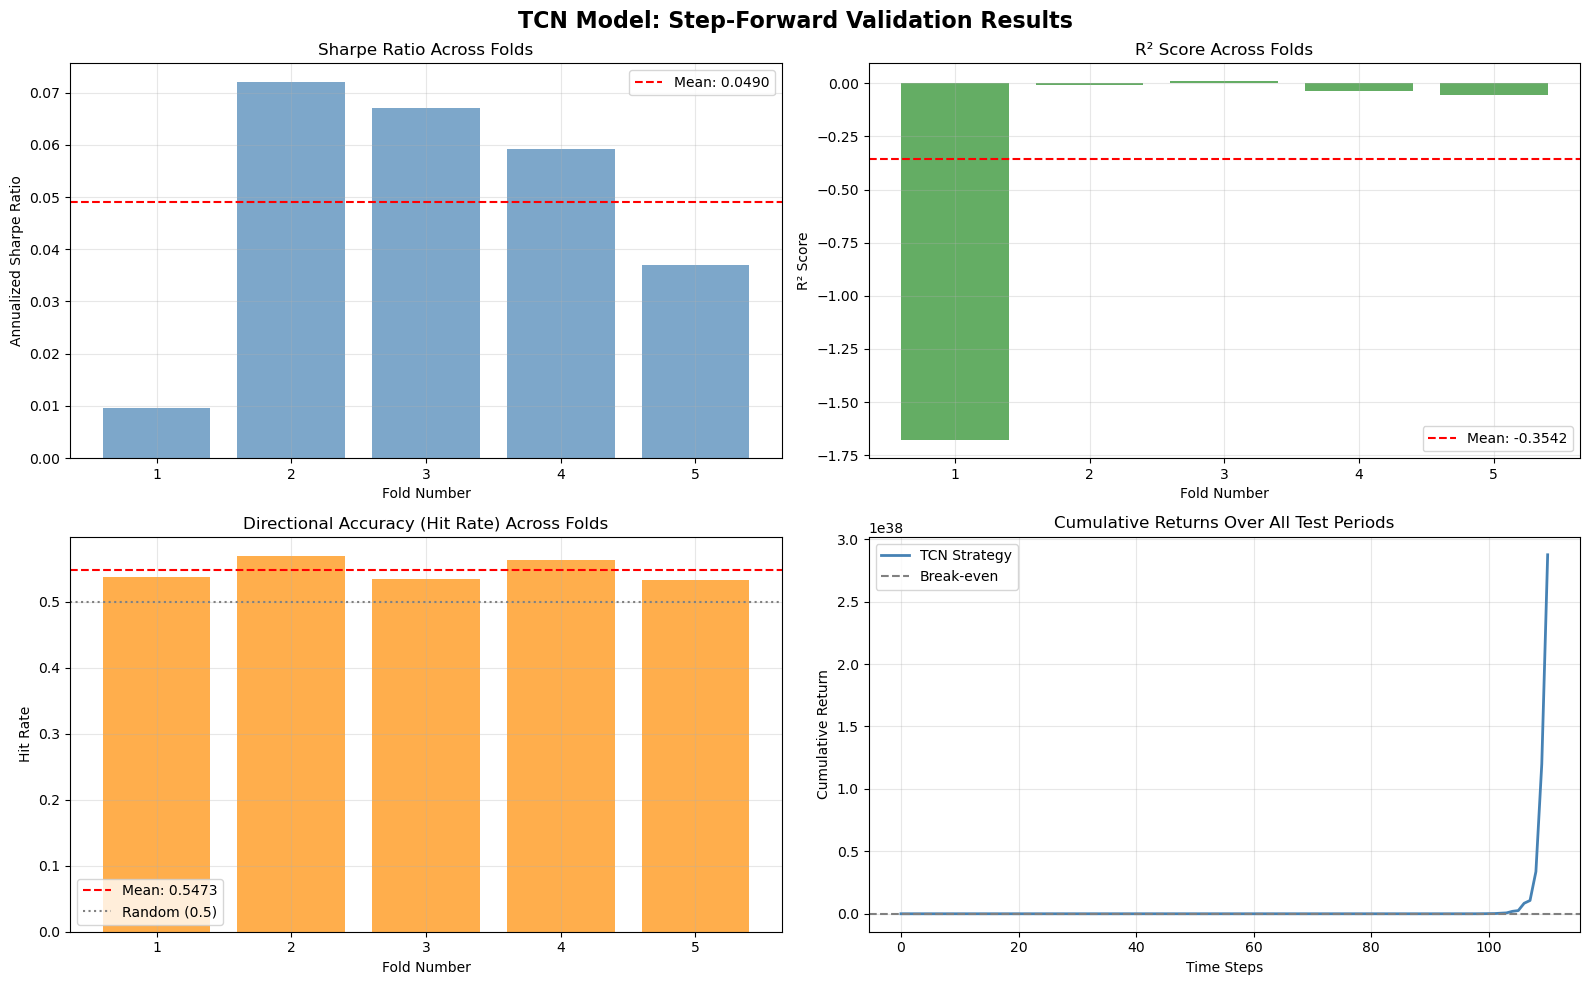


DETAILED STATISTICS

Sharpe Ratio:
  Min: 0.0096
  Max: 0.0720
  Median: 0.0591
  Std Dev: 0.0230

R² Score:
  Min: -1.6799
  Max: 0.0093
  Median: -0.0368
  Std Dev: 0.6632

Hit Rate:
  Min: 0.5323
  Max: 0.5698
  Median: 0.5369
  Std Dev: 0.0158

Final Cumulative Return: inf
Total Return: inf%


In [23]:
# Visualize Step-Forward Validation Results

# Concatenate all predictions and true values
all_test_indices_flat = np.concatenate(all_test_indices)
all_y_true_flat = np.concatenate(all_y_true)
all_tcn_preds_flat = np.concatenate(all_tcn_preds)

# Calculate cumulative returns
def calculate_cumulative_returns(predictions, true_returns):
    """Calculate cumulative returns from predictions and true returns."""
    strategy_returns = predictions * true_returns
    cumulative_returns = (1 + strategy_returns).cumprod()
    return cumulative_returns

# Get returns for plotting (need to extract from original data)
# We'll use the allocation as a proxy since we don't have direct returns
cumulative_tcn = calculate_cumulative_returns(all_tcn_preds_flat, all_y_true_flat)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('TCN Model: Step-Forward Validation Results', fontsize=16, fontweight='bold')

# 1. Sharpe Ratio across folds
axes[0, 0].bar(range(1, fold_num + 1), tcn_sharpe_scores, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=np.mean(tcn_sharpe_scores), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(tcn_sharpe_scores):.4f}')
axes[0, 0].set_xlabel('Fold Number')
axes[0, 0].set_ylabel('Annualized Sharpe Ratio')
axes[0, 0].set_title('Sharpe Ratio Across Folds')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. R² Score across folds
axes[0, 1].bar(range(1, fold_num + 1), tcn_r2_scores, color='forestgreen', alpha=0.7)
axes[0, 1].axhline(y=np.mean(tcn_r2_scores), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(tcn_r2_scores):.4f}')
axes[0, 1].set_xlabel('Fold Number')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('R² Score Across Folds')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Hit Rate across folds
axes[1, 0].bar(range(1, fold_num + 1), tcn_hit_rates, color='darkorange', alpha=0.7)
axes[1, 0].axhline(y=np.mean(tcn_hit_rates), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(tcn_hit_rates):.4f}')
axes[1, 0].axhline(y=0.5, color='gray', linestyle=':', label='Random (0.5)')
axes[1, 0].set_xlabel('Fold Number')
axes[1, 0].set_ylabel('Hit Rate')
axes[1, 0].set_title('Directional Accuracy (Hit Rate) Across Folds')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative Returns
axes[1, 1].plot(range(len(cumulative_tcn)), cumulative_tcn, 
                label='TCN Strategy', linewidth=2, color='steelblue')
axes[1, 1].axhline(y=1.0, color='gray', linestyle='--', label='Break-even')
axes[1, 1].set_xlabel('Time Steps')
axes[1, 1].set_ylabel('Cumulative Return')
axes[1, 1].set_title('Cumulative Returns Over All Test Periods')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print("\n" + "="*60)
print("DETAILED STATISTICS")
print("="*60)
print(f"\nSharpe Ratio:")
print(f"  Min: {np.min(tcn_sharpe_scores):.4f}")
print(f"  Max: {np.max(tcn_sharpe_scores):.4f}")
print(f"  Median: {np.median(tcn_sharpe_scores):.4f}")
print(f"  Std Dev: {np.std(tcn_sharpe_scores):.4f}")

print(f"\nR² Score:")
print(f"  Min: {np.min(tcn_r2_scores):.4f}")
print(f"  Max: {np.max(tcn_r2_scores):.4f}")
print(f"  Median: {np.median(tcn_r2_scores):.4f}")
print(f"  Std Dev: {np.std(tcn_r2_scores):.4f}")

print(f"\nHit Rate:")
print(f"  Min: {np.min(tcn_hit_rates):.4f}")
print(f"  Max: {np.max(tcn_hit_rates):.4f}")
print(f"  Median: {np.median(tcn_hit_rates):.4f}")
print(f"  Std Dev: {np.std(tcn_hit_rates):.4f}")

print(f"\nFinal Cumulative Return: {cumulative_tcn[-1]:.4f}")
print(f"Total Return: {(cumulative_tcn[-1] - 1) * 100:.2f}%")
print("="*60)

## Cumulative Performance Comparison


--- Generating Cumulative Performance Plot ---


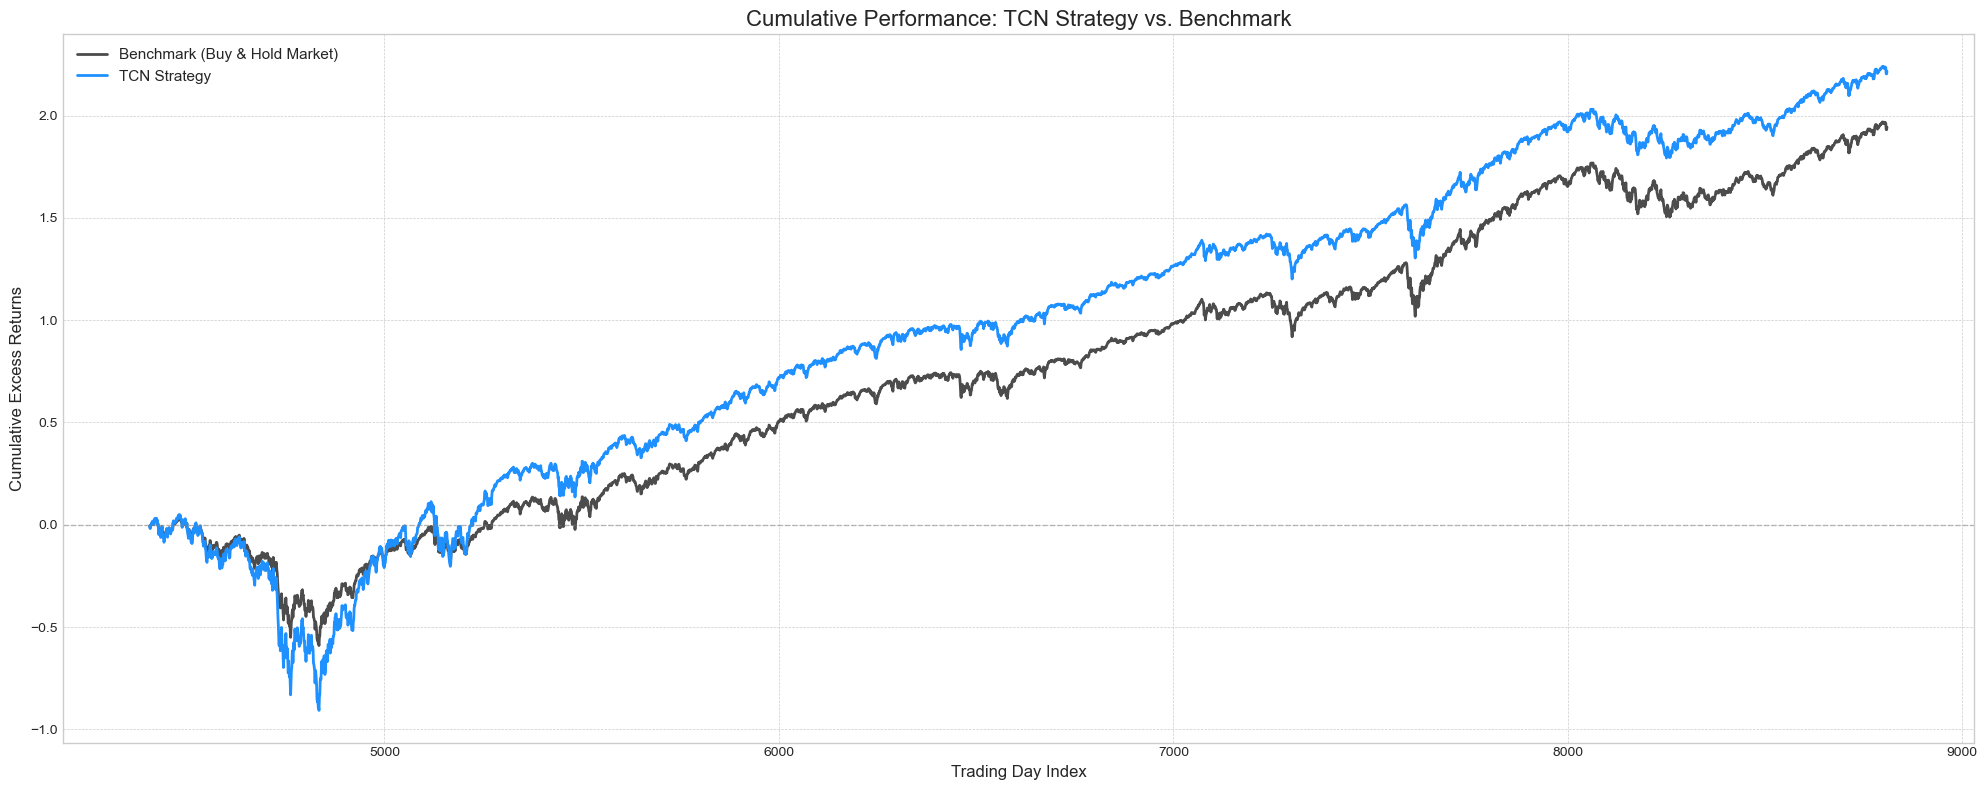


CUMULATIVE PERFORMANCE SUMMARY
Benchmark Final Cumulative Return: 1.9432
TCN Strategy Final Cumulative Return: 2.2156
Outperformance: 0.2724

Benchmark Total Return: 194.32%
TCN Strategy Total Return: 221.56%


In [24]:
# Plot cumulative performance: CNN Strategy vs Benchmark

print("\n--- Generating Cumulative Performance Plot ---")

if all_test_indices:
    # Concatenate all test data from step-forward validation
    combined_indices = np.concatenate(all_test_indices)
    combined_tcn_preds = np.concatenate(all_tcn_preds)
    
    # Get actual returns for benchmark (need to align with test indices)
    # Extract adjusted returns for the test periods
    benchmark_returns_list = []
    for idx_array in all_test_indices:
        benchmark_returns_list.append(train_df.loc[idx_array, 'adjusted_return'].values)
    benchmark_returns = pd.Series(
        np.concatenate(benchmark_returns_list), 
        index=combined_indices, 
        name="Benchmark Returns"
    )
    
    # TCN predictions as positions (allocations)
    tcn_preds_series = pd.Series(
        combined_tcn_preds, 
        index=combined_indices, 
        name="TCN Predictions"
    )
    
    # Calculate strategy returns
    # Benchmark: Buy & Hold Market (just the raw returns)
    benchmark_cumulative = benchmark_returns
    
    # TCN Strategy: Position * Market Return
    # The predictions are already allocations (0-2), so we use them directly
    tcn_positions = np.clip(tcn_preds_series.values, 0, 2)
    tcn_strategy_returns = pd.Series(
        tcn_positions * benchmark_returns.values, 
        index=benchmark_returns.index,
        name="TCN Strategy Returns"
    )
    
    # Calculate cumulative returns (equity curve)
    cumulative_benchmark = benchmark_cumulative.cumsum()
    cumulative_tcn_strategy = tcn_strategy_returns.cumsum()
    
    # Create plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))
    
    # Plot cumulative return curves
    plt.plot(cumulative_benchmark, 
             label='Benchmark (Buy & Hold Market)', 
             color='black', 
             linewidth=2, 
             alpha=0.7)
    plt.plot(cumulative_tcn_strategy, 
             label='TCN Strategy', 
             color='dodgerblue', 
             linewidth=2)
    
    # Add chart elements
    plt.title('Cumulative Performance: TCN Strategy vs. Benchmark', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel('Cumulative Excess Returns', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Display plot
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("CUMULATIVE PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Benchmark Final Cumulative Return: {cumulative_benchmark.iloc[-1]:.4f}")
    print(f"TCN Strategy Final Cumulative Return: {cumulative_tcn_strategy.iloc[-1]:.4f}")
    print(f"Outperformance: {(cumulative_tcn_strategy.iloc[-1] - cumulative_benchmark.iloc[-1]):.4f}")
    print(f"\nBenchmark Total Return: {(cumulative_benchmark.iloc[-1]) * 100:.2f}%")
    print(f"TCN Strategy Total Return: {(cumulative_tcn_strategy.iloc[-1]) * 100:.2f}%")
    print("="*60)
else:
    print("No validation data available. Please run step-forward validation first.")

## Per-Fold Performance Visualization


--- Generating Per-Fold Performance Plots ---



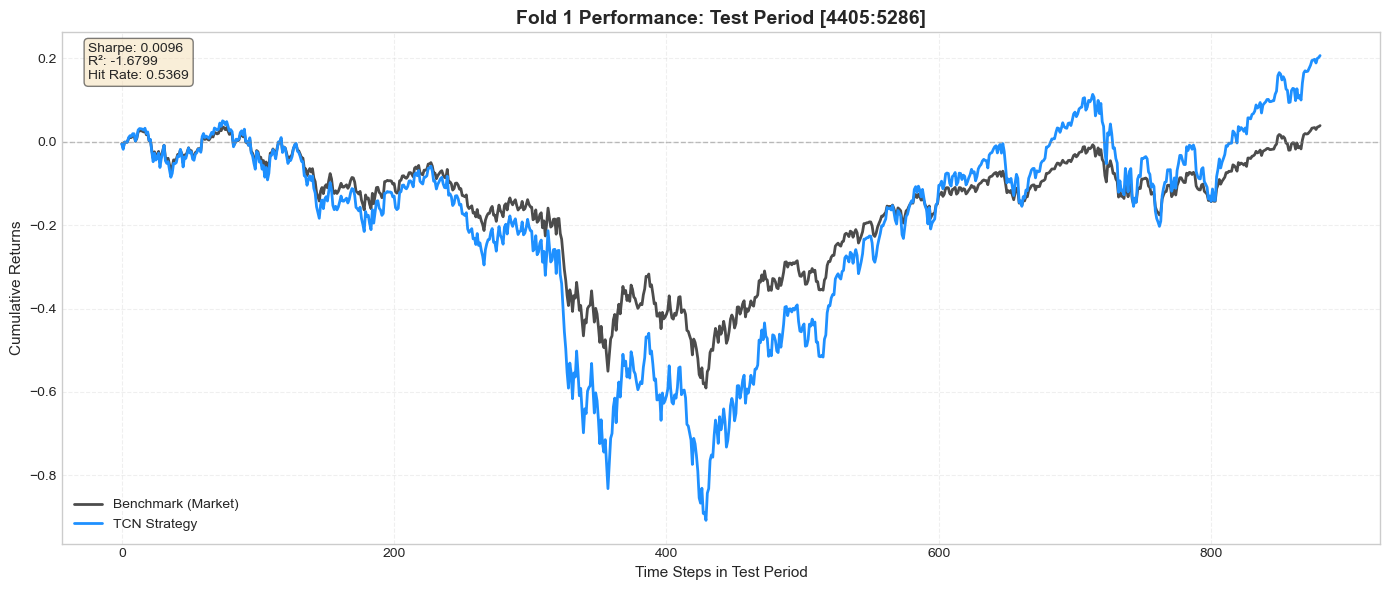

Fold 1: Benchmark Final = 0.0381, TCN Final = 0.2059, Outperformance = 0.1678


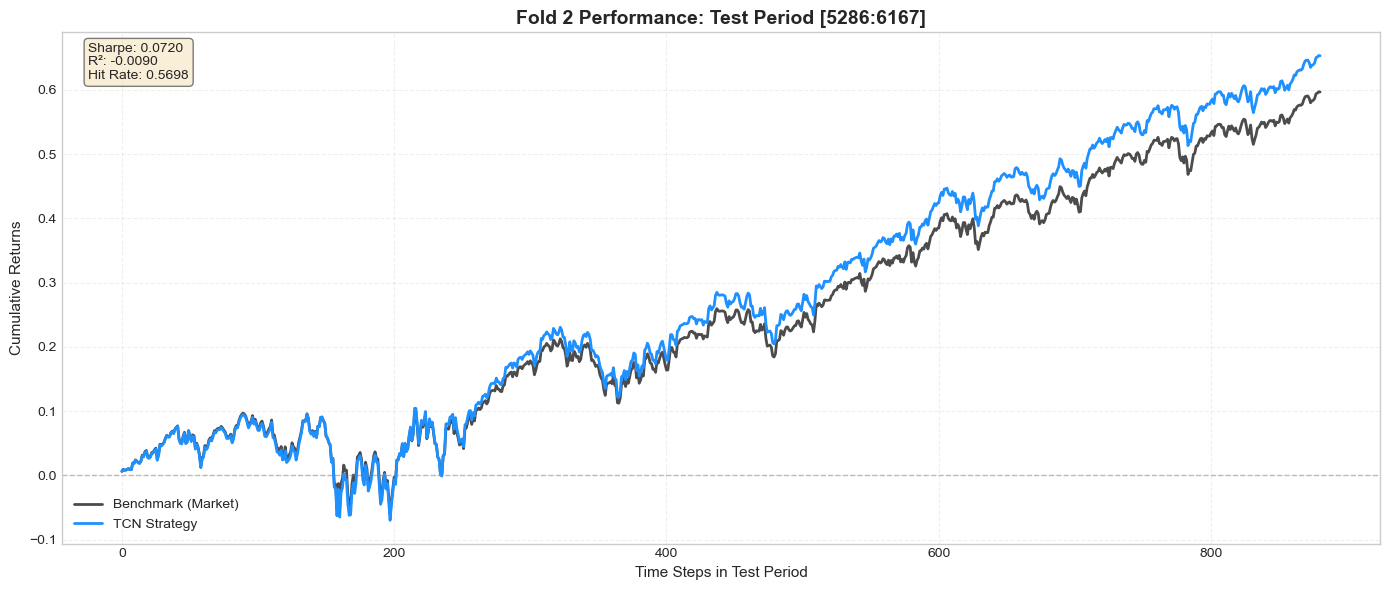

Fold 2: Benchmark Final = 0.5967, TCN Final = 0.6531, Outperformance = 0.0564


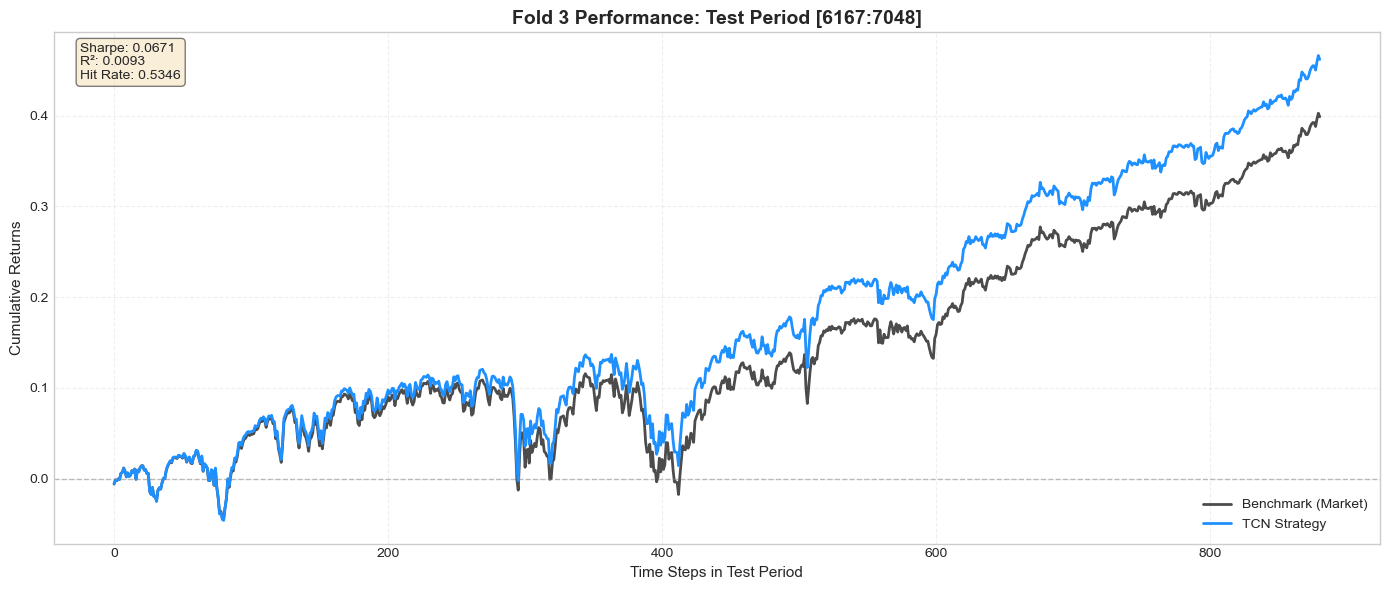

Fold 3: Benchmark Final = 0.3989, TCN Final = 0.4621, Outperformance = 0.0632


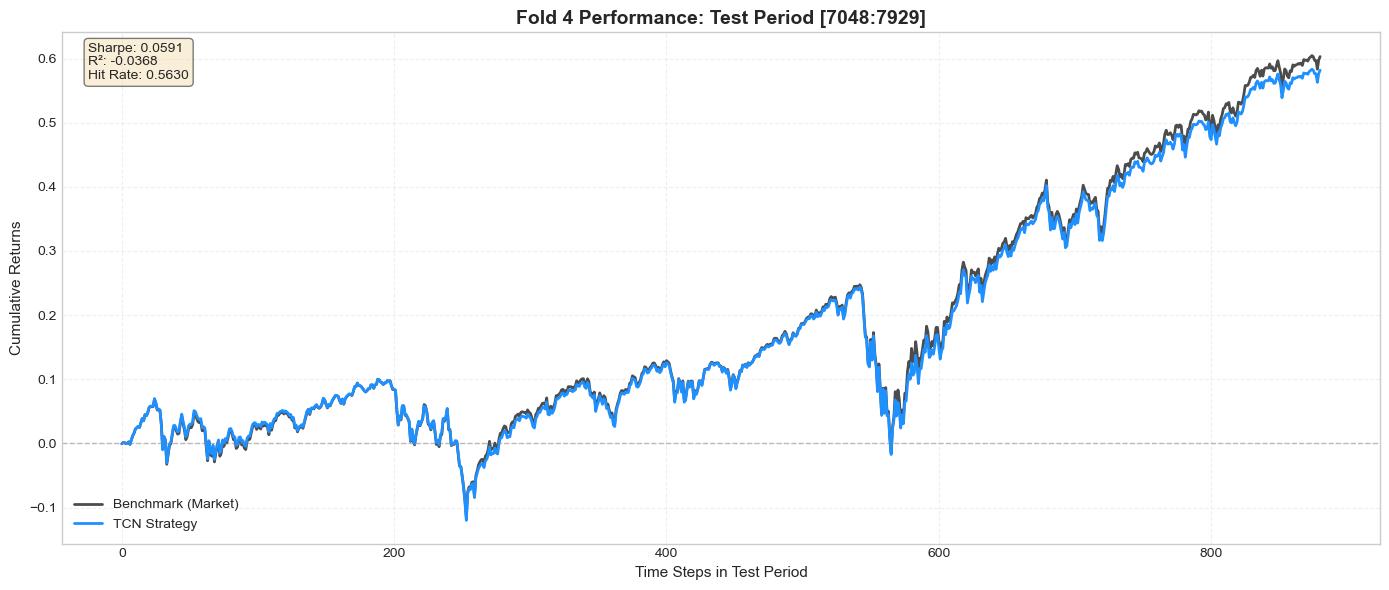

Fold 4: Benchmark Final = 0.6030, TCN Final = 0.5817, Outperformance = -0.0213


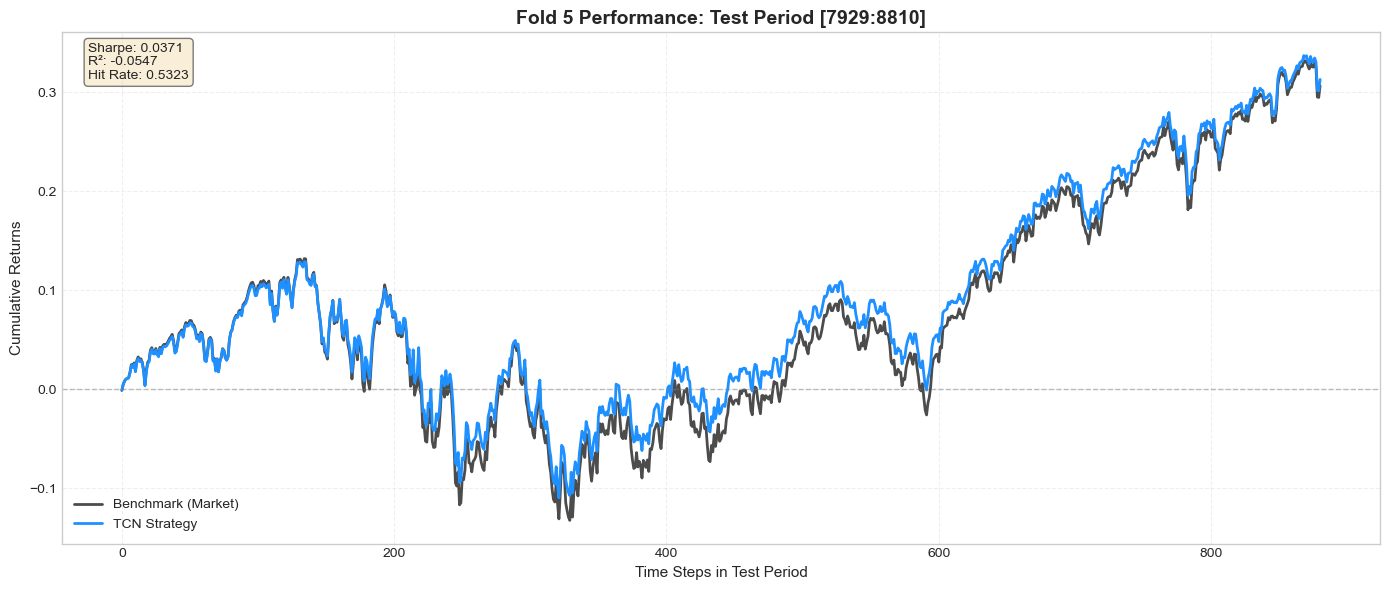

Fold 5: Benchmark Final = 0.3065, TCN Final = 0.3128, Outperformance = 0.0063

Completed plotting all 5 folds


In [25]:
# Plot cumulative performance for each fold individually

print("\n--- Generating Per-Fold Performance Plots ---\n")

if all_test_indices and all_tcn_preds:
    # Get the test period boundaries for labeling
    test_periods = []
    temp_train_start = 0
    temp_train_end = initial_train_size
    temp_test_end = temp_train_end + test_size
    
    for i in range(len(all_test_indices)):
        test_periods.append((temp_train_end, temp_test_end))
        temp_train_start += test_size
        temp_train_end += test_size
        temp_test_end += test_size
    
    # Create individual plots for each fold
    for fold_idx in range(len(all_test_indices)):
        fold_num = fold_idx + 1
        
        # Get data for this fold
        fold_preds = all_tcn_preds[fold_idx]
        fold_true = all_y_true[fold_idx]
        fold_indices = all_test_indices[fold_idx]
        
        # Get actual returns for this fold
        fold_returns = train_df.loc[fold_indices, 'adjusted_return'].values
        
        # Calculate strategy returns
        fold_tcn_positions = np.clip(fold_preds, 0, 2)
        fold_tcn_strategy_returns = fold_tcn_positions * fold_returns
        
        # Calculate cumulative returns
        fold_cumulative_benchmark = np.cumsum(fold_returns)
        fold_cumulative_tcn = np.cumsum(fold_tcn_strategy_returns)
        
        # Get metrics for this fold
        fold_sharpe = tcn_sharpe_scores[fold_idx]
        fold_r2 = tcn_r2_scores[fold_idx]
        fold_hit_rate = tcn_hit_rates[fold_idx]
        
        # Create plot for this fold
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 6))
        
        plt.plot(fold_cumulative_benchmark, 
                 label='Benchmark (Market)', 
                 color='black', 
                 linewidth=2, 
                 alpha=0.7)
        plt.plot(fold_cumulative_tcn, 
                 label='TCN Strategy', 
                 color='dodgerblue', 
                 linewidth=2)
        
        # Add title with test period info
        train_end_idx, test_end_idx = test_periods[fold_idx]
        plt.title(f'Fold {fold_num} Performance: Test Period [{train_end_idx}:{test_end_idx}]', 
                  fontsize=14, fontweight='bold')
        plt.xlabel('Time Steps in Test Period', fontsize=11)
        plt.ylabel('Cumulative Returns', fontsize=11)
        plt.legend(fontsize=10, loc='best')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        
        # Add text box with metrics
        textstr = f'Sharpe: {fold_sharpe:.4f}\nR²: {fold_r2:.4f}\nHit Rate: {fold_hit_rate:.4f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, 
                 fontsize=10, verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.show()
        
        # Print fold summary
        print(f"Fold {fold_num}: Benchmark Final = {fold_cumulative_benchmark[-1]:.4f}, "
              f"TCN Final = {fold_cumulative_tcn[-1]:.4f}, "
              f"Outperformance = {(fold_cumulative_tcn[-1] - fold_cumulative_benchmark[-1]):.4f}")
    
    print(f"\n{'='*60}")
    print("Completed plotting all {0} folds".format(len(all_test_indices)))
    print(f"{'='*60}")
else:
    print("No validation data available. Please run step-forward validation first.")

# Final Test Set Evaluation

Evaluate the best model from step-forward validation on the held-out test set that was set aside at the beginning.

In [26]:
# Test on the held-out test set (N_TEST_ROWS = 63 samples)

print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)
print(f"\nEvaluating on held-out test set: {len(X_test)} samples")

# Use the best model from the last fold (or load the best saved model)
# For this evaluation, we'll use the last trained fold_model
# Alternatively, you can train a final model on all training data

# We already have X_test, y_test from the beginning
# Get test returns for Sharpe calculation
test_returns_holdout = train_df.loc[X_test.index, 'adjusted_return']

print(f"Test set size: {len(X_test)}")
print(f"Test returns available: {len(test_returns_holdout)}")

# Apply feature engineering to test set (already done above as X_test_scaled)
# Create windows for test set (already done as Xw_test, yw_test, rw_test)

# Make predictions using the last trained model (or load best model)
fold_model.eval()
test_preds = []
test_true = []
test_returns_list = []

with torch.no_grad():
    for X_batch, y_batch, r_batch in test_loader:
        X_batch = X_batch.to('cuda')
        outputs = fold_model(X_batch)
        test_preds.extend(outputs.cpu().numpy())
        test_true.extend(y_batch.numpy())
        test_returns_list.extend(r_batch.numpy())

test_preds = np.array(test_preds).flatten()
test_true = np.array(test_true)
test_returns_array = np.array(test_returns_list)

# Calculate metrics using base-v1 methodology
test_sharpe = ad_sharpe_ratio_scorer(test_preds, test_returns_array)
test_r2 = r2_score(test_true, test_preds)
test_hit_rate = np.mean(np.sign(test_returns_array) == np.sign(test_preds))

print(f"\n{'='*60}")
print("TEST SET METRICS")
print(f"{'='*60}")
print(f"Sharpe Ratio (Non-Annualized): {test_sharpe:.4f}")
print(f"R² Score: {test_r2:.4f}")
print(f"Hit Rate: {test_hit_rate:.4f}")
print(f"{'='*60}\n")

# Annualized Sharpe for comparison
strategy_returns_test = test_preds * test_returns_array
test_sharpe_annualized = (strategy_returns_test.mean() / strategy_returns_test.std()) * np.sqrt(180) if strategy_returns_test.std() > 0 else 0.0
print(f"Sharpe Ratio (Annualized): {test_sharpe_annualized:.4f}\n")


FINAL TEST SET EVALUATION

Evaluating on held-out test set: 180 samples
Test set size: 180
Test returns available: 180

TEST SET METRICS
Sharpe Ratio (Non-Annualized): 0.0257
R² Score: -0.0531
Hit Rate: 0.5473

Sharpe Ratio (Annualized): 0.3451



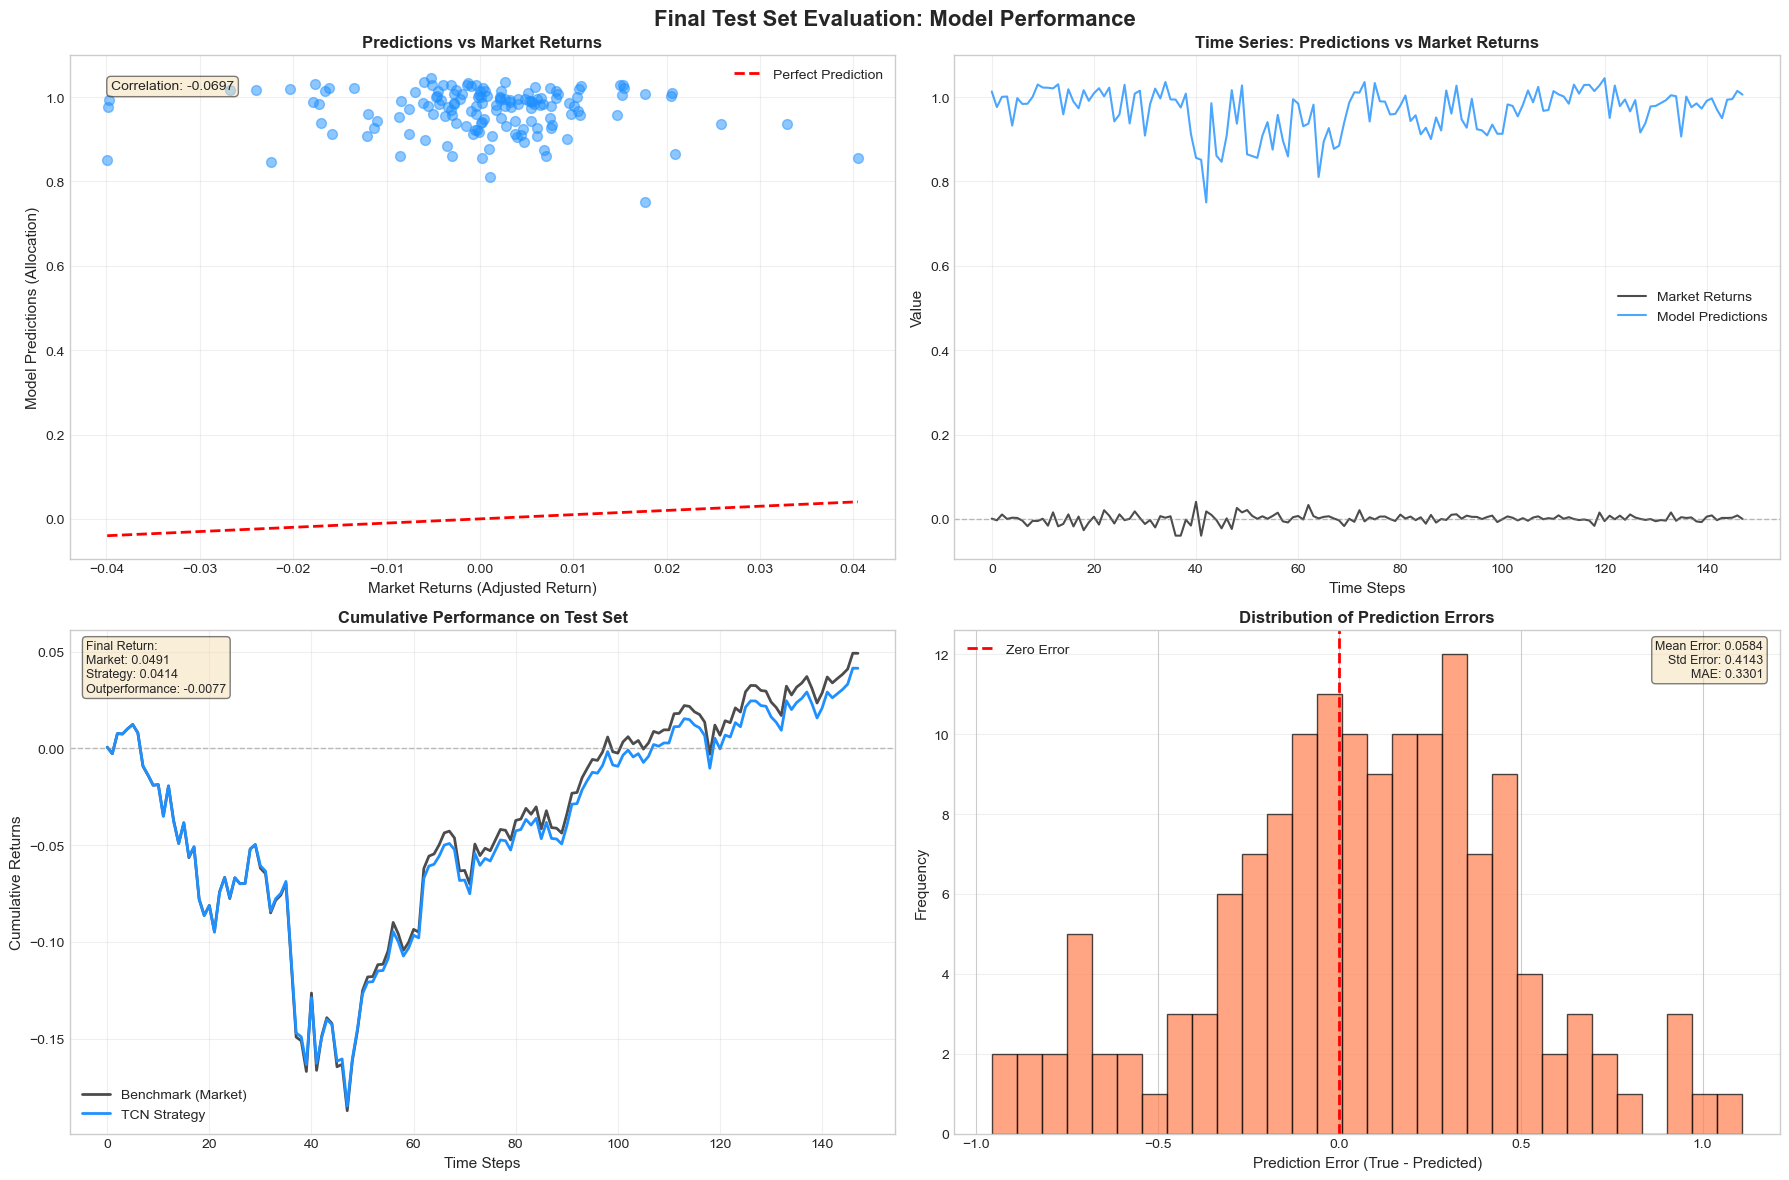


DETAILED TEST SET ANALYSIS

Prediction Statistics:
  Mean Prediction: 0.9681
  Std Prediction: 0.0523
  Min Prediction: 0.7504
  Max Prediction: 1.0448

Market Returns Statistics:
  Mean Return: 0.0003
  Std Return: 0.0114
  Min Return: -0.0399
  Max Return: 0.0405

Strategy Returns Statistics:
  Mean Strategy Return: 0.0003
  Std Strategy Return: 0.0109
  Total Cumulative Return (Market): 0.0491 (4.91%)
  Total Cumulative Return (Strategy): 0.0414 (4.14%)
  Outperformance: -0.0077

Directional Accuracy:
  Correct Direction Predictions: 81 / 148
  Hit Rate: 0.5473 (54.73%)

Model Quality Metrics:
  R² Score: -0.0531
  Correlation (Predictions vs Returns): -0.0697
  Mean Absolute Error: 0.3301
  Mean Squared Error: 0.1751
  Root Mean Squared Error: 0.4184


In [27]:
# Plot predictions vs market returns for test set

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Final Test Set Evaluation: Model Performance', fontsize=16, fontweight='bold')

# 1. Predictions vs Market Returns (Scatter)
axes[0, 0].scatter(test_returns_array, test_preds, alpha=0.5, s=50, color='dodgerblue')
axes[0, 0].plot([test_returns_array.min(), test_returns_array.max()], 
                [test_returns_array.min(), test_returns_array.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Market Returns (Adjusted Return)', fontsize=11)
axes[0, 0].set_ylabel('Model Predictions (Allocation)', fontsize=11)
axes[0, 0].set_title('Predictions vs Market Returns', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add correlation text
corr = np.corrcoef(test_returns_array, test_preds)[0, 1]
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr:.4f}', 
                transform=axes[0, 0].transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Time Series: Predictions and Market Returns
test_indices = y_test.index[WINDOW:]  # Account for windowing
axes[0, 1].plot(range(len(test_returns_array)), test_returns_array, 
                label='Market Returns', color='black', linewidth=1.5, alpha=0.7)
axes[0, 1].plot(range(len(test_preds)), test_preds, 
                label='Model Predictions', color='dodgerblue', linewidth=1.5, alpha=0.8)
axes[0, 1].set_xlabel('Time Steps', fontsize=11)
axes[0, 1].set_ylabel('Value', fontsize=11)
axes[0, 1].set_title('Time Series: Predictions vs Market Returns', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# 3. Cumulative Returns Comparison
test_positions = np.clip(test_preds, 0, 2)
test_strategy_returns = test_positions * test_returns_array
cumulative_market = np.cumsum(test_returns_array)
cumulative_strategy = np.cumsum(test_strategy_returns)

axes[1, 0].plot(range(len(cumulative_market)), cumulative_market,
                label='Benchmark (Market)', color='black', linewidth=2, alpha=0.7)
axes[1, 0].plot(range(len(cumulative_strategy)), cumulative_strategy,
                label='TCN Strategy', color='dodgerblue', linewidth=2)
axes[1, 0].set_xlabel('Time Steps', fontsize=11)
axes[1, 0].set_ylabel('Cumulative Returns', fontsize=11)
axes[1, 0].set_title('Cumulative Performance on Test Set', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add performance metrics text
perf_text = f'Final Return:\nMarket: {cumulative_market[-1]:.4f}\nStrategy: {cumulative_strategy[-1]:.4f}\nOutperformance: {(cumulative_strategy[-1] - cumulative_market[-1]):.4f}'
axes[1, 0].text(0.02, 0.98, perf_text, 
                transform=axes[1, 0].transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Distribution of Prediction Errors
prediction_errors = test_true - test_preds
axes[1, 1].hist(prediction_errors, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].set_xlabel('Prediction Error (True - Predicted)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add error statistics
mean_error = prediction_errors.mean()
std_error = prediction_errors.std()
error_text = f'Mean Error: {mean_error:.4f}\nStd Error: {std_error:.4f}\nMAE: {np.abs(prediction_errors).mean():.4f}'
axes[1, 1].text(0.98, 0.98, error_text, 
                transform=axes[1, 1].transAxes, 
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed summary
print("\n" + "="*60)
print("DETAILED TEST SET ANALYSIS")
print("="*60)
print(f"\nPrediction Statistics:")
print(f"  Mean Prediction: {test_preds.mean():.4f}")
print(f"  Std Prediction: {test_preds.std():.4f}")
print(f"  Min Prediction: {test_preds.min():.4f}")
print(f"  Max Prediction: {test_preds.max():.4f}")

print(f"\nMarket Returns Statistics:")
print(f"  Mean Return: {test_returns_array.mean():.4f}")
print(f"  Std Return: {test_returns_array.std():.4f}")
print(f"  Min Return: {test_returns_array.min():.4f}")
print(f"  Max Return: {test_returns_array.max():.4f}")

print(f"\nStrategy Returns Statistics:")
print(f"  Mean Strategy Return: {test_strategy_returns.mean():.4f}")
print(f"  Std Strategy Return: {test_strategy_returns.std():.4f}")
print(f"  Total Cumulative Return (Market): {cumulative_market[-1]:.4f} ({cumulative_market[-1]*100:.2f}%)")
print(f"  Total Cumulative Return (Strategy): {cumulative_strategy[-1]:.4f} ({cumulative_strategy[-1]*100:.2f}%)")
print(f"  Outperformance: {(cumulative_strategy[-1] - cumulative_market[-1]):.4f}")

print(f"\nDirectional Accuracy:")
print(f"  Correct Direction Predictions: {int(test_hit_rate * len(test_returns_array))} / {len(test_returns_array)}")
print(f"  Hit Rate: {test_hit_rate:.4f} ({test_hit_rate*100:.2f}%)")

print(f"\nModel Quality Metrics:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  Correlation (Predictions vs Returns): {corr:.4f}")
print(f"  Mean Absolute Error: {np.abs(prediction_errors).mean():.4f}")
print(f"  Mean Squared Error: {(prediction_errors**2).mean():.4f}")
print(f"  Root Mean Squared Error: {np.sqrt((prediction_errors**2).mean()):.4f}")

print("="*60)

# Appendix: Temporal Convolutional Network (TCN) Architecture

## Overview

This project implements a **Temporal Convolutional Network (TCN)** for financial market prediction. TCNs are a specialized deep learning architecture designed for sequence modeling tasks that require long-range temporal dependencies while maintaining causal constraints (i.e., predictions at time $t$ cannot use information from time $t+1$ or later).

## Architecture Components

### 1. Temporal Block Structure

Each **TemporalBlock** is the fundamental building unit of the TCN, consisting of:

#### A. Dilated Causal Convolutions
- **Purpose**: Expand the receptive field exponentially without increasing computational cost
- **Dilation rate**: Increases as $2^i$ where $i$ is the block level
  - Level 0: dilation = 1 (looks at consecutive time steps)
  - Level 1: dilation = 2 (skips every other time step)
  - Level 2: dilation = 4 (skips 3 time steps between samples)
  - Level 3: dilation = 8 (skips 7 time steps between samples)

**Receptive field calculation**:
For a kernel size $k=3$ and $L=4$ levels:

$$\text{Receptive Field} = 1 + 2 \times \sum_{i=0}^{L-1}(k-1) \times 2^i = 1 + 2 \times (2 \times 1 + 2 \times 2 + 2 \times 4 + 2 \times 8) = 61 \text{ time steps}$$

This means the model can "see" the past 61 days of market history when making a prediction.

#### B. Weight Normalization
- **Implementation**: `torch.nn.utils.parametrizations.weight_norm`
- **Purpose**: Stabilizes training by reparameterizing weights as:
  $$\mathbf{w} = g \frac{\mathbf{v}}{\|\mathbf{v}\|}$$
  where $g$ is a learned scalar and $\mathbf{v}$ is the weight vector
- **Benefit**: Prevents exploding/vanishing gradients common in deep temporal models

#### C. Causal Padding and Chomp Layer
- **Problem**: Standard convolution sees "future" information
- **Solution**: Apply left-padding, then "chomp" (remove) the rightmost outputs
- **Formula**: 
  $$\text{padding} = (k-1) \times d$$
  where $k$ is kernel size and $d$ is dilation
- **Result**: Output at time $t$ only depends on inputs $\{x_1, x_2, \ldots, x_t\}$

#### D. Residual Connections
- Inspired by ResNet architecture
- Allows gradient flow through identity mappings
- **Forward pass**:
  $$\mathbf{y} = \text{ReLU}(\mathcal{F}(\mathbf{x}) + \mathbf{x})$$
  where $\mathcal{F}(\mathbf{x})$ is the convolution transformation
- **Downsampling**: When input/output dimensions differ, a 1×1 convolution projects $\mathbf{x}$ to match

#### E. Regularization
- **Dropout**: Applied after each ReLU activation (default rate = 0.2)
- **Purpose**: Prevents overfitting by randomly dropping neurons during training

### 2. Full Network Architecture

The complete **MarketTCN** model consists of:

```
Input: (Batch, Features, Window)  
  where Features = 37 (financial indicators)
  and   Window = 32 (time steps)

↓

[TemporalBlock 0] (dilation=1, channels: Features → 64)
↓
[TemporalBlock 1] (dilation=2, channels: 64 → 64)
↓
[TemporalBlock 2] (dilation=4, channels: 64 → 64)
↓
[TemporalBlock 3] (dilation=8, channels: 64 → 64)

↓
Extract last time step: (Batch, 64, Window) → (Batch, 64)

↓
[Linear Head] (64 → 1)

↓
[Sigmoid × 2.0] Maps to allocation range [0, 2]

↓
Output: (Batch, 1) - Predicted allocation
```

### 3. Key Hyperparameters

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| **Window Size** | 32 | Captures approximately 1.5 months of trading days |
| **Hidden Channels** | 64 | Balances model capacity with computational efficiency |
| **Number of Levels** | 4 | Provides receptive field of 61 days |
| **Kernel Size** | 3 | Standard for temporal convolutions |
| **Dropout Rate** | 0.2 | Standard regularization strength |
| **Batch Size** | 32 | Fits in GPU memory while maintaining gradient stability |
| **Learning Rate** | 1×10⁻⁴ | Works well with AdamW optimizer |

### 4. Training Configuration

#### Loss Function
- **SmoothL1Loss** (Huber Loss)
- **Formula**:
  $$L(y, \hat{y}) = \begin{cases}
  0.5(y - \hat{y})^2 & \text{if } |y - \hat{y}| < 1 \\
  |y - \hat{y}| - 0.5 & \text{otherwise}
  \end{cases}$$
- **Advantage**: Less sensitive to outliers than MSE, crucial for financial data with extreme market events

#### Optimizer
- **AdamW** with weight decay = 1×10⁻⁴
- Decouples weight decay from gradient updates, improving generalization

#### Learning Rate Schedule
- **OneCycleLR**: Warms up learning rate, then gradually decreases
- Helps escape local minima early in training

#### Gradient Clipping
- **Max norm** = 1.0
- Prevents exploding gradients during volatile market periods

### 5. Why TCN for Financial Forecasting?

| Feature | Benefit for Finance |
|---------|---------------------|
| **Causal convolutions** | Ensures no forward-looking bias (realistic trading simulation) |
| **Dilated convolutions** | Captures both short-term patterns (daily moves) and long-term trends (quarterly cycles) |
| **Parallelizable** | Unlike RNNs, all time steps train simultaneously → faster convergence |
| **Stable gradients** | Weight normalization + residual connections prevent vanishing gradients |
| **Fixed receptive field** | More interpretable than attention mechanisms for regime detection |

### 6. Comparison to Alternatives

| Model Type | Pros | Cons | TCN Advantage |
|------------|------|------|---------------|
| **LSTM/GRU** | Good for sequences | Sequential training (slow), gradient issues | 3-5× faster, more stable |
| **Transformer** | Attention mechanism | Requires massive data, no causality guarantee | Built-in causality, works with smaller datasets |
| **1D CNN** | Fast, parallel | Limited receptive field | Dilated convolutions solve this |
| **MLP** | Simple | No temporal structure | TCN preserves temporal ordering |

### 7. Model Output Interpretation

The model predicts an **allocation weight** $w_t \in [0, 2]$:
- $w_t = 0.0$: Full cash position (bearish signal)
- $w_t = 1.0$: Neutral market exposure
- $w_t = 2.0$: Maximum leverage (bullish signal)

**Strategy return** at time $t$:
$$r_{\text{strategy}}(t) = w_t \times r_{\text{market}}(t)$$

where $r_{\text{market}}(t)$ is the excess return over the risk-free rate.

### 8. Performance Metrics

The model is evaluated using:
1. **Sharpe Ratio**: Risk-adjusted returns (annualized)
2. **R² Score**: Prediction accuracy vs. target allocations
3. **Hit Rate**: Directional accuracy (% correct sign predictions)
4. **Cumulative Returns**: Total strategy performance vs. buy-and-hold

---

## Mathematical Notation Summary

- $x_t$: Input features at time $t$
- $k$: Kernel size
- $d$: Dilation rate
- $L$: Number of TCN levels
- $w_t$: Predicted allocation
- $r_t$: Market return
- $\mathcal{F}(\cdot)$: Convolutional transformation
- $\sigma(\cdot)$: Sigmoid activation
- $\text{ReLU}(x) = \max(0, x)$

---

**Reference**: This architecture is based on "An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling" (Bai et al., 2018), adapted for financial time series prediction with domain-specific modifications.